In [58]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
#import cvutils as cvu
import cv2
import math
import os 
from os import path
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            #slope = (y2-y1)/(x2-x1)
            angle = (np.rad2deg(np.arctan2(y1 - y2, x1 - x2)))
            print('steering angle : ', angle)
            if (angle<-120.0 and angle>-150.0) or (angle>=120.0 and angle<=150.0):
                print('steering angle : ', angle)
                cv2.line(img, (x1, y1), (x2, y2), color, thickness)
            

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    color=(255, 0, 0)
    draw_lines(line_img, lines,color,3)
    return line_img

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

def process_image(path):
    #reading in an image
    #print('Path : ',path)
    if type(path) == str :
        image = mpimg.imread(path)
    else :
        image = path
    #printing out some stats and plotting
    print('This image is:', type(image), 'with dimesions:', image.shape)
    #plt.imshow(image)  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image

    #Converting image to grayscale
    grayimg = grayscale(image)
    #plt.imshow(grayimg, cmap='gray')

    #Smoothing the image with gaussian noise using correlation
    kernel_size=7
    blurgrayimg = gaussian_blur(grayimg, kernel_size)

    # Define our parameters for Canny and apply
    low_threshold = 50
    high_threshold = 100
    cnedges=canny(blurgrayimg,low_threshold,high_threshold)

    # This time we are defining a four sided polygon to mask
    imshape = image.shape
    #vertices = np.array([[(0,imshape[0]),(0, 0), (imshape[1], 0), (imshape[1],imshape[0])]], dtype=np.int32)
    vertices = np.array([[[460,320],[500,320],[900,550],[100,550]]],dtype=np.int32)
    roi = region_of_interest(cnedges,vertices)
    #plt.imshow(roi, cmap='gray')

    # Definmpimg.imshow(masked_edges)e the Hough transform parameters
    # Make a blank the same size as our image to draw on
    rho = 2 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 50    # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 10 #minimum number of pixels making up a line
    max_line_gap =  20   # maximum gap in pixels between connectable line segments

    hgimg = hough_lines(roi, rho, theta, threshold, min_line_length, max_line_gap)
    #plt.imshow(hgimg, cmap='gray')


    #coledges = np.dstack((cnedges,cnedges,cnedges))
    lineimage = weighted_img(hgimg, image, α=0.8, β=1, λ=0.)
    #plt.figure()
    #plt.imshow(lineimage)
    return lineimage
    
def processBatchImage(dirPath):
    files = [x for x in os.listdir(dirPath) if path.isfile(dirPath+os.sep+x)]
    for f in files :
        plt.figure()
        plt.imshow(process_image(dirPath+os.sep+f))
    
    return 

#processBatchImage("test_images/")
def process_video(output,input) :
    white_output = output
    clip1 = VideoFileClip(input)
    white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
    %time white_clip.write_videofile(white_output, audio=False)

    return """
    <video width="960" height="540" controls>
      <source src="{0}">
    </video>
    """.format(white_output)
    
#HTML(process_video('white.mp4',"solidWhiteRight.mp4"))

#HTML(process_video('yellow.mp4',"solidYellowLeft.mp4"))

'''The Challenge'''
HTML(process_video('extra.mp4',"challenge.mp4"))


This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
steering angle :  176.790513682
steering angle :  176.037045802
steering angle :  165.242680674
steering angle :  148.069317896
steering angle :  148.069317896
steering angle :  177.157862116
steering angle :  165.136208379
steering angle :  146.309932474
steering angle :  146.309932474
steering angle :  145.539183729
steering angle :  145.539183729
steering angle :  176.947117485
steering angle :  176.125326796
steering angle :  164.814162738
steering angle :  172.17092349
steering angle :  147.264773728
steering angle :  147.264773728
steering angle :  180.0
steering angle :  -147.828782871
steering angle :  -147.828782871
steering angle :  146.560130794
steering angle :  146.560130794
steering angle :  -162.645975364
steering angle :  149.910313761
steering angle :  149.910313761
steering angle :  -143.130102354
steering angle :  -143.130102354
steering angle :  180.0
steering angle :  149.264512298
steering angle





  0%|          | 0/251 [00:00<?, ?it/s]



  1%|          | 2/251 [00:00<00:18, 13.70it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
steering angle :  176.790513682
steering angle :  176.037045802
steering angle :  165.242680674
steering angle :  148.069317896
steering angle :  148.069317896
steering angle :  177.157862116
steering angle :  165.136208379
steering angle :  146.309932474
steering angle :  146.309932474
steering angle :  145.539183729
steering angle :  145.539183729
steering angle :  176.947117485
steering angle :  176.125326796
steering angle :  164.814162738
steering angle :  172.17092349
steering angle :  147.264773728
steering angle :  147.264773728
steering angle :  180.0
steering angle :  -147.828782871
steering angle :  -147.828782871
steering angle :  146.560130794
steering angle :  146.560130794
steering angle :  -162.645975364
steering angle :  149.910313761
steering angle :  149.910313761
steering angle :  -143.130102354
steering angle :  -143.130102354
steering angle :  180.0
steering angle :  149.264512298
steering angle





  1%|          | 3/251 [00:00<00:20, 12.31it/s]



  2%|▏         | 5/251 [00:00<00:18, 13.00it/s]

steering angle :  177.137594774
steering angle :  146.164880178
steering angle :  146.164880178
steering angle :  164.99868154
steering angle :  176.009086902
steering angle :  165.191622961
steering angle :  176.905941941
steering angle :  147.150911041
steering angle :  147.150911041
steering angle :  177.878903603
steering angle :  176.278686735
steering angle :  176.633539337
steering angle :  177.273689006
steering angle :  176.054813771
steering angle :  164.995079617
steering angle :  164.419076152
steering angle :  164.898901839
steering angle :  180.0
steering angle :  -146.309932474
steering angle :  -146.309932474
steering angle :  180.0
steering angle :  176.124593805
steering angle :  150.018360631
steering angle :  180.0
steering angle :  180.0
steering angle :  -158.962488975
steering angle :  167.005383208
steering angle :  176.682218832
steering angle :  -162.34987578
steering angle :  165.5297059
steering angle :  166.759480085
steering angle :  180.0
steering angle :





  3%|▎         | 7/251 [00:00<00:19, 12.74it/s]

steering angle :  176.03968817
steering angle :  164.716698427
steering angle :  175.975771532
steering angle :  146.938150495
steering angle :  146.938150495
steering angle :  164.931511841
steering angle :  165.465544919
steering angle :  145.974382697
steering angle :  145.974382697
steering angle :  165.963756532
steering angle :  166.065164885
steering angle :  176.889159347
steering angle :  165.963756532
steering angle :  -149.036243468
steering angle :  -149.036243468
steering angle :  175.971736334
steering angle :  174.957548931
steering angle :  176.358814742
steering angle :  146.575188817
steering angle :  146.575188817
steering angle :  176.185925166
steering angle :  175.51539399
steering angle :  -144.605204155
steering angle :  -144.605204155
steering angle :  -145.007979801
steering angle :  -145.007979801
steering angle :  -147.030596097
steering angle :  -147.030596097
steering angle :  146.309932474
steering angle :  146.309932474
steering angle :  -171.027373385
s





  4%|▎         | 9/251 [00:00<00:17, 13.46it/s]



  4%|▍         | 11/251 [00:00<00:17, 13.91it/s]

steering angle :  145.988651096
steering angle :  145.988651096
steering angle :  164.140633733
steering angle :  165.01456419
steering angle :  145.6849124
steering angle :  145.6849124
steering angle :  -149.588918733
steering angle :  -149.588918733
steering angle :  147.094757077
steering angle :  147.094757077
steering angle :  177.039063866
steering angle :  -147.264773728
steering angle :  -147.264773728
steering angle :  158.838740183
steering angle :  164.577838681
steering angle :  177.336999234
steering angle :  -164.931511841
steering angle :  -164.407189061
steering angle :  -146.976132444
steering angle :  -146.976132444
steering angle :  -149.184294248
steering angle :  -149.184294248
steering angle :  174.289406863
steering angle :  164.577838681
steering angle :  -161.939528064
steering angle :  -148.240519915
steering angle :  -148.240519915
steering angle :  -162.050597007
steering angle :  171.119340849
steering angle :  175.994229964
steering angle :  -149.03624346





  5%|▌         | 13/251 [00:00<00:17, 13.89it/s]



  6%|▌         | 15/251 [00:01<00:16, 14.68it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
steering angle :  176.566369638
steering angle :  175.962289379
steering angle :  176.121475497
steering angle :  145.278719804
steering angle :  145.278719804
steering angle :  163.570698548
steering angle :  164.773572221
steering angle :  176.987212496
steering angle :  164.560354465
steering angle :  144.102622488
steering angle :  144.102622488
steering angle :  163.241041583
steering angle :  168.690067526
steering angle :  167.949215117
steering angle :  -148.392497754
steering angle :  -148.392497754
steering angle :  175.236358309
steering angle :  176.905941941
steering angle :  -166.263731694
steering angle :  164.931511841
steering angle :  -170.19390724
steering angle :  174.289406863
steering angle :  176.099506258
steering angle :  -149.036243468
steering angle :  -149.036243468
steering angle :  157.890551656
steering angle :  164.859016165
steering angle :  176.378515296
steering angle :  176.0232690





  7%|▋         | 17/251 [00:01<00:16, 14.58it/s]

steering angle :  176.01310512
steering angle :  166.759480085
steering angle :  175.979432896
steering angle :  163.379243086
steering angle :  144.004779125
steering angle :  144.004779125
steering angle :  146.076549734
steering angle :  146.076549734
steering angle :  164.054604099
steering angle :  163.66395711
steering angle :  177.026268918
steering angle :  168.878539805
steering angle :  147.901072745
steering angle :  147.901072745
steering angle :  162.34987578
steering angle :  175.995827059
steering angle :  -147.652556501
steering angle :  -147.652556501
steering angle :  175.763605201
steering angle :  176.633539337
steering angle :  178.152389734
steering angle :  -169.3150876
steering angle :  163.779806304
steering angle :  -166.809389288
steering angle :  -168.023867556
steering angle :  -147.264773728
steering angle :  -147.264773728
steering angle :  179.33380003
steering angle :  -175.030259272
steering angle :  147.724355685
steering angle :  147.724355685
steeri





  8%|▊         | 19/251 [00:01<00:15, 14.81it/s]



  8%|▊         | 21/251 [00:01<00:15, 15.01it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
steering angle :  164.992734601
steering angle :  176.121475497
steering angle :  164.969569477
steering angle :  177.709389957
steering angle :  145.996272581
steering angle :  145.996272581
steering angle :  180.0
steering angle :  178.94881925
steering angle :  175.985824305
steering angle :  144.09995036
steering angle :  144.09995036
steering angle :  174.623294572
steering angle :  165.5297059
steering angle :  165.963756532
steering angle :  175.236358309
steering angle :  176.933514499
steering angle :  -148.815025341
steering angle :  -148.815025341
steering angle :  -150.255118703
steering angle :  -147.319445257
steering angle :  -147.319445257
steering angle :  175.446232021
steering angle :  175.292147756
steering angle :  164.649863508
steering angle :  164.389011466
steering angle :  -168.95905982
steering angle :  173.418055345
steering angle :  -168.486168816
steering angle :  168.886959464
steering 





  9%|▉         | 23/251 [00:01<00:14, 15.53it/s]



 10%|▉         | 25/251 [00:01<00:14, 15.74it/s]

steering angle :  164.94568344
steering angle :  175.997489348
steering angle :  175.851096302
steering angle :  143.054414446
steering angle :  143.054414446
steering angle :  145.145544434
steering angle :  145.145544434
steering angle :  164.773572221
steering angle :  176.074092296
steering angle :  164.32717949
steering angle :  180.0
steering angle :  176.877869538
steering angle :  -168.929797422
steering angle :  165.379126011
steering angle :  167.774877324
steering angle :  145.407711312
steering angle :  145.407711312
steering angle :  178.191260678
steering angle :  -168.996459148
steering angle :  143.471144633
steering angle :  143.471144633
steering angle :  157.96377306
steering angle :  -152.102728969
steering angle :  176.633539337
steering angle :  -148.570434385
steering angle :  -148.570434385
steering angle :  -134.060809054
steering angle :  -134.060809054
steering angle :  -166.504266719
steering angle :  177.646703134
steering angle :  -149.420773128
steering a





 11%|█         | 27/251 [00:01<00:14, 15.01it/s]



 12%|█▏        | 29/251 [00:01<00:14, 15.28it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
steering angle :  176.917819175
steering angle :  164.156917882
steering angle :  177.137594774
steering angle :  145.210867691
steering angle :  145.210867691
steering angle :  143.935613843
steering angle :  143.935613843
steering angle :  175.51539399
steering angle :  163.425992243
steering angle :  176.373428216
steering angle :  180.0
steering angle :  -148.172553423
steering angle :  -148.172553423
steering angle :  168.11134196
steering angle :  180.0
steering angle :  156.037511025
steering angle :  165.963756532
steering angle :  175.724158887
steering angle :  150.78075331
steering angle :  180.0
steering angle :  -162.121303404
steering angle :  176.729512077
steering angle :  -147.264773728
steering angle :  -147.264773728
steering angle :  176.248270929
steering angle :  167.275644315
steering angle :  -166.759480085
steering angle :  176.054813771
steering angle :  -145.750966993
steering angle :  -145





 12%|█▏        | 31/251 [00:02<00:15, 14.11it/s]



 13%|█▎        | 33/251 [00:02<00:14, 15.26it/s]

steering angle :  163.990764817
steering angle :  176.960600431
steering angle :  166.293038996
steering angle :  147.03720232
steering angle :  147.03720232
steering angle :  176.929605659
steering angle :  163.974132552
steering angle :  176.855042535
steering angle :  146.05641298
steering angle :  146.05641298
steering angle :  167.96279768
steering angle :  -147.994616792
steering angle :  -147.994616792
steering angle :  144.462322208
steering angle :  144.462322208
steering angle :  -149.534455081
steering angle :  -149.534455081
steering angle :  -146.309932474
steering angle :  -146.309932474
steering angle :  155.095231192
steering angle :  -149.588918733
steering angle :  -149.588918733
steering angle :  153.904575843
steering angle :  -176.149361176
steering angle :  -149.381394591
steering angle :  -149.381394591
steering angle :  -164.744881297
steering angle :  -164.44542873
steering angle :  171.027373385
steering angle :  -169.695153531
steering angle :  -148.736268306





 14%|█▍        | 35/251 [00:02<00:15, 14.31it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
steering angle :  177.113581456
steering angle :  164.962184096
steering angle :  149.913495446
steering angle :  149.913495446
steering angle :  176.227716391
steering angle :  180.0
steering angle :  176.139267375
steering angle :  149.300277449
steering angle :  149.300277449
steering angle :  163.960056694
steering angle :  176.82016988
steering angle :  180.0
steering angle :  147.264773728
steering angle :  147.264773728
steering angle :  164.744881297
steering angle :  175.7321067
steering angle :  167.005383208
steering angle :  173.990994043
steering angle :  175.030259272
steering angle :  145.944219699
steering angle :  145.944219699
steering angle :  -147.264773728
steering angle :  -147.264773728
steering angle :  -148.570434385
steering angle :  -148.570434385
steering angle :  180.0
steering angle :  -169.286876977
steering angle :  -149.036243468
steering angle :  -149.036243468
steering angle :  -168





 15%|█▍        | 37/251 [00:02<00:15, 14.02it/s]



 16%|█▌        | 39/251 [00:02<00:14, 15.03it/s]

steering angle :  166.013149433
steering angle :  177.155344395
steering angle :  176.308614014
steering angle :  148.134022306
steering angle :  148.134022306
steering angle :  180.0
steering angle :  149.879721752
steering angle :  149.879721752
steering angle :  177.797401838
steering angle :  176.780505103
steering angle :  165.963756532
steering angle :  144.293308599
steering angle :  144.293308599
steering angle :  180.0
steering angle :  -178.058513609
steering angle :  150.945395901
steering angle :  167.735226272
steering angle :  164.475889003
steering angle :  180.0
steering angle :  180.0
steering angle :  -178.058513609
steering angle :  165.555964276
steering angle :  180.0
steering angle :  -168.326289687
steering angle :  176.997727412
steering angle :  -155.55604522
steering angle :  146.12918929
steering angle :  146.12918929
steering angle :  -171.253837737
steering angle :  -149.420773128
steering angle :  -149.420773128
steering angle :  -149.534455081
steering an





 16%|█▋        | 41/251 [00:02<00:14, 14.45it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
steering angle :  176.860339852
steering angle :  165.963756532
steering angle :  165.000353286
steering angle :  176.937712915
steering angle :  164.375765419
steering angle :  146.534620654
steering angle :  146.534620654
steering angle :  146.309932474
steering angle :  146.309932474
steering angle :  146.976132444
steering angle :  146.976132444
steering angle :  148.891191171
steering angle :  148.891191171
steering angle :  165.343248884
steering angle :  149.712047009
steering angle :  149.712047009
steering angle :  164.553683632
steering angle :  172.030389606
steering angle :  174.644174957
steering angle :  -167.735226272
steering angle :  174.400660663
steering angle :  175.68397248
steering angle :  -168.178511659
steering angle :  -146.309932474
steering angle :  -146.309932474
steering angle :  -144.958070598
steering angle :  -144.958070598
steering angle :  164.99868154
steering angle :  -147.0947570





 17%|█▋        | 43/251 [00:03<00:24,  8.51it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
steering angle :  165.161768255
steering angle :  177.064326554
steering angle :  176.185925166
steering angle :  165.124317998
steering angle :  177.273689006
steering angle :  145.954062643
steering angle :  145.954062643
steering angle :  147.578935237
steering angle :  147.578935237
steering angle :  180.0
steering angle :  176.455233544
steering angle :  -150.140983835
steering angle :  180.0
steering angle :  149.036243468
steering angle :  149.036243468
steering angle :  180.0
steering angle :  176.25383795
steering angle :  176.185925166
steering angle :  -147.425942865
steering angle :  -147.425942865
steering angle :  180.0
steering angle :  165.191622961
steering angle :  169.950651412
steering angle :  -179.10482629
steering angle :  -165.963756532
steering angle :  148.964891351
steering angle :  148.964891351
steering angle :  178.451842301
steering angle :  -167.957424857
steering angle :  -156.9486990





 18%|█▊        | 45/251 [00:03<00:24,  8.28it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
steering angle :  165.106527041
steering angle :  176.855042535
steering angle :  175.086201238
steering angle :  165.048322646
steering angle :  180.0
steering angle :  180.0
steering angle :  147.077669162
steering angle :  147.077669162
steering angle :  145.175510843
steering angle :  145.175510843
steering angle :  177.510447078
steering angle :  177.709389957
steering angle :  -168.690067526
steering angle :  176.185925166
steering angle :  174.289406863
steering angle :  175.42607874
steering angle :  173.437301491
steering angle :  180.0
steering angle :  173.290163192
steering angle :  176.682218832
steering angle :  167.660912722
steering angle :  -150.255118703
steering angle :  175.785821477
steering angle :  171.193207306
steering angle :  180.0
steering angle :  -164.521361835
steering angle :  -150.708637829
steering angle :  180.0
steering angle :  -178.090847567
steering angle :  165.555964276
steeri





 19%|█▊        | 47/251 [00:03<00:26,  7.72it/s]



 19%|█▉        | 48/251 [00:03<00:27,  7.40it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
steering angle :  164.891896037
steering angle :  164.205461516
steering angle :  176.698134326
steering angle :  176.355510487
steering angle :  180.0
steering angle :  177.00295742
steering angle :  144.979921146
steering angle :  144.979921146
steering angle :  146.309932474
steering angle :  146.309932474
steering angle :  176.054813771
steering angle :  -174.805571092
steering angle :  -167.005383208
steering angle :  -160.201123645
steering angle :  176.185925166
steering angle :  180.0
steering angle :  -170.3802722
steering angle :  -149.931417178
steering angle :  -149.931417178
steering angle :  180.0
steering angle :  147.804266065
steering angle :  147.804266065
steering angle :  -150.945395901
steering angle :  -150.255118703
steering angle :  -153.904575843
steering angle :  -150.524110997
steering angle :  -150.642246457
steering angle :  180.0
steering angle :  -146.976132444
steering angle :  -146.97





 20%|█▉        | 49/251 [00:04<00:29,  6.84it/s]

steering angle :  163.300755766
steering angle :  165.004920871
steering angle :  176.03968817
steering angle :  164.305075857
steering angle :  176.221802293
steering angle :  145.045330369
steering angle :  145.045330369
steering angle :  147.022276686
steering angle :  147.022276686
steering angle :  171.929767822
steering angle :  180.0
steering angle :  177.878903603
steering angle :  180.0
steering angle :  -157.067899562
steering angle :  -164.001699424
steering angle :  176.987212496
steering angle :  165.379126011
steering angle :  180.0
steering angle :  167.12499844
steering angle :  176.455233544
steering angle :  146.673710313
steering angle :  146.673710313
steering angle :  171.027373385
steering angle :  171.119340849
steering angle :  176.035345277
steering angle :  173.088772881
steering angle :  165.963756532
steering angle :  174.805571092
steering angle :  -162.718501628
steering angle :  -157.479434397
steering angle :  173.118276369
steering angle :  -158.0088700





 20%|█▉        | 50/251 [00:04<00:30,  6.63it/s]



 20%|██        | 51/251 [00:04<00:30,  6.49it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
steering angle :  164.931511841
steering angle :  164.981639369
steering angle :  176.7689901
steering angle :  180.0
steering angle :  145.304846469
steering angle :  145.304846469
steering angle :  180.0
steering angle :  175.901698744
steering angle :  146.200797788
steering angle :  146.200797788
steering angle :  164.019082852
steering angle :  144.202596972
steering angle :  144.202596972
steering angle :  175.100907546
steering angle :  175.643024994
steering angle :  145.669782804
steering angle :  145.669782804
steering angle :  -164.380607861
steering angle :  174.805571092
steering angle :  176.074092296
steering angle :  -149.036243468
steering angle :  -149.036243468
steering angle :  171.253837737
steering angle :  175.42607874
steering angle :  145.713123023
steering angle :  145.713123023
steering angle :  -175.126103578
steering angle :  -150.642246457
steering angle :  175.601294645
steering angle :





 21%|██        | 52/251 [00:04<00:32,  6.22it/s]

steering angle :  176.01310512
steering angle :  165.113733151
steering angle :  176.185925166
steering angle :  165.004920871
steering angle :  145.175510843
steering angle :  145.175510843
steering angle :  147.067768959
steering angle :  147.067768959
steering angle :  144.111357045
steering angle :  144.111357045
steering angle :  176.716137712
steering angle :  173.659808254
steering angle :  -152.447188423
steering angle :  180.0
steering angle :  -149.858614448
steering angle :  -149.858614448
steering angle :  180.0
steering angle :  -154.983106522
steering angle :  -151.927513064
steering angle :  -157.027278669
steering angle :  178.830860672
steering angle :  -170.286748975
steering angle :  -154.653824058
steering angle :  -151.927513064
steering angle :  -151.606980579
steering angle :  168.690067526
steering angle :  175.995827059
steering angle :  178.531199286
steering angle :  147.528807709
steering angle :  147.528807709
steering angle :  -149.036243468
steering angle





 21%|██        | 53/251 [00:04<00:33,  5.96it/s]



 22%|██▏       | 54/251 [00:05<00:32,  6.11it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
steering angle :  177.357454706
steering angle :  164.596575038
steering angle :  165.650667957
steering angle :  180.0
steering angle :  176.185925166
steering angle :  176.288716192
steering angle :  164.305075857
steering angle :  149.300277449
steering angle :  149.300277449
steering angle :  165.012438029
steering angle :  146.309932474
steering angle :  146.309932474
steering angle :  -149.036243468
steering angle :  -149.036243468
steering angle :  144.027612951
steering angle :  144.027612951
steering angle :  145.933816786
steering angle :  145.933816786
steering angle :  177.754257434
steering angle :  165.749967302
steering angle :  -148.392497754
steering angle :  -148.392497754
steering angle :  165.5297059
steering angle :  178.122122553
steering angle :  -148.861027563
steering angle :  -148.861027563
steering angle :  -150.802513954
steering angle :  176.099506258
steering angle :  177.510447078
steer





 22%|██▏       | 55/251 [00:05<00:33,  5.81it/s]

steering angle :  165.018367428
steering angle :  165.039711179
steering angle :  176.794784069
steering angle :  176.054813771
steering angle :  164.357753543
steering angle :  149.82647997
steering angle :  149.82647997
steering angle :  147.042575143
steering angle :  147.042575143
steering angle :  176.7480544
steering angle :  177.61405597
steering angle :  180.0
steering angle :  -148.091893064
steering angle :  -148.091893064
steering angle :  -147.87500156
steering angle :  -147.87500156
steering angle :  145.007979801
steering angle :  145.007979801
steering angle :  176.82016988
steering angle :  -174.193273094
steering angle :  -170.190697752
steering angle :  -155.973493421
steering angle :  -169.695153531
steering angle :  -174.986886245
steering angle :  -160.676815682
steering angle :  -149.036243468
steering angle :  -149.036243468
steering angle :  -175.601294645
steering angle :  -161.312648495
steering angle :  -155.87159707
steering angle :  180.0
steering angle :  





 22%|██▏       | 56/251 [00:05<00:34,  5.61it/s]



 23%|██▎       | 57/251 [00:05<00:33,  5.72it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
steering angle :  164.957199254
steering angle :  180.0
steering angle :  180.0
steering angle :  176.987212496
steering angle :  176.95162506
steering angle :  145.203973722
steering angle :  145.203973722
steering angle :  165.097345761
steering angle :  149.036243468
steering angle :  149.036243468
steering angle :  176.185925166
steering angle :  145.871452926
steering angle :  145.871452926
steering angle :  177.137594774
steering angle :  -156.139824809
steering angle :  177.137594774
steering angle :  143.84181456
steering angle :  143.84181456
steering angle :  -152.896132925
steering angle :  -152.801872051
steering angle :  -176.15396991
steering angle :  164.240477833
steering angle :  -174.472459848
steering angle :  180.0
steering angle :  171.869897646
steering angle :  169.242032912
steering angle :  177.316224841
steering angle :  -150.802513954
steering angle :  142.49585764
steering angle :  142.495





 23%|██▎       | 58/251 [00:05<00:34,  5.54it/s]

steering angle :  178.264295411
steering angle :  164.986634206
steering angle :  163.892866266
steering angle :  176.804061986
steering angle :  147.724355685
steering angle :  147.724355685
steering angle :  180.0
steering angle :  146.309932474
steering angle :  146.309932474
steering angle :  176.045752284
steering angle :  150.101098161
steering angle :  174.289406863
steering angle :  146.121460195
steering angle :  146.121460195
steering angle :  179.10482629
steering angle :  180.0
steering angle :  177.878903603
steering angle :  180.0
steering angle :  177.563351753
steering angle :  144.88140612
steering angle :  144.88140612
steering angle :  180.0
steering angle :  164.054604099
steering angle :  165.033280436
steering angle :  171.869897646
steering angle :  -156.991129917
steering angle :  164.320475878
steering angle :  176.308614014
steering angle :  175.236358309
steering angle :  -173.018942593
steering angle :  -160.016893478
steering angle :  -156.037511025
steerin





 24%|██▎       | 59/251 [00:05<00:35,  5.48it/s]



 24%|██▍       | 60/251 [00:06<00:33,  5.65it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
steering angle :  179.181544538
steering angle :  164.054604099
steering angle :  146.113040536
steering angle :  146.113040536
steering angle :  164.962184096
steering angle :  177.865741237
steering angle :  180.0
steering angle :  146.938150495
steering angle :  146.938150495
steering angle :  180.0
steering angle :  180.0
steering angle :  164.916940178
steering angle :  176.34777722
steering angle :  176.633539337
steering angle :  175.855376259
steering angle :  177.580490783
steering angle :  180.0
steering angle :  180.0
steering angle :  171.869897646
steering angle :  180.0
steering angle :  145.840305454
steering angle :  145.840305454
steering angle :  -179.204276447
steering angle :  175.236358309
steering angle :  -176.185925166
steering angle :  180.0
steering angle :  176.185925166
steering angle :  180.0
steering angle :  175.100907546
steering angle :  180.0
steering angle :  174.805571092
steering 





 24%|██▍       | 61/251 [00:06<00:33,  5.59it/s]

steering angle :  176.367049261
steering angle :  180.0
steering angle :  164.13841064
steering angle :  176.022259354
steering angle :  145.669782804
steering angle :  145.669782804
steering angle :  147.994616792
steering angle :  147.994616792
steering angle :  163.523118606
steering angle :  180.0
steering angle :  175.985824305
steering angle :  -173.969991192
steering angle :  -175.196514241
steering angle :  -165.027124233
steering angle :  146.05641298
steering angle :  146.05641298
steering angle :  165.963756532
steering angle :  164.931511841
steering angle :  163.141601232
steering angle :  -173.125181971
steering angle :  -170.909723079
steering angle :  175.030259272
steering angle :  144.958070598
steering angle :  144.958070598
steering angle :  180.0
steering angle :  179.236101539
steering angle :  162.050597007
steering angle :  -156.801409486
steering angle :  -157.380135052
steering angle :  168.310630825
steering angle :  -162.897271031
steering angle :  167.90524





 25%|██▍       | 62/251 [00:06<00:33,  5.57it/s]



 25%|██▌       | 63/251 [00:06<00:31,  5.89it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
steering angle :  164.161999999
steering angle :  175.928186106
steering angle :  176.185925166
steering angle :  146.082569463
steering angle :  146.082569463
steering angle :  164.248826337
steering angle :  163.300755766
steering angle :  147.075288583
steering angle :  147.075288583
steering angle :  169.992020199
steering angle :  175.155999625
steering angle :  162.474431626
steering angle :  140.906141114
steering angle :  140.906141114
steering angle :  180.0
steering angle :  -148.928341939
steering angle :  -148.928341939
steering angle :  -167.005383208
steering angle :  180.0
steering angle :  180.0
steering angle :  180.0
steering angle :  -167.228757435
steering angle :  -161.075355584
steering angle :  180.0
steering angle :  -167.560437981
steering angle :  -171.724107173
steering angle :  168.476278296
steering angle :  -169.950651412
steering angle :  180.0
steering angle :  -160.346175942
steering 





 25%|██▌       | 64/251 [00:06<00:32,  5.76it/s]

steering angle :  176.969523154
steering angle :  163.85566122
steering angle :  164.962184096
steering angle :  147.994616792
steering angle :  147.994616792
steering angle :  164.134292197
steering angle :  163.221545061
steering angle :  177.01853878
steering angle :  145.097504384
steering angle :  145.097504384
steering angle :  176.905941941
steering angle :  180.0
steering angle :  177.4208525
steering angle :  164.054604099
steering angle :  -166.865977694
steering angle :  168.381475647
steering angle :  177.904747435
steering angle :  162.84757826
steering angle :  163.986758329
steering angle :  177.904747435
steering angle :  180.0
steering angle :  -158.198590514
steering angle :  -176.82016988
steering angle :  -169.114472945
steering angle :  -165.84236735
steering angle :  -153.434948823
steering angle :  -157.619864948
steering angle :  180.0
steering angle :  180.0
steering angle :  180.0
steering angle :  -173.571252251
steering angle :  150.945395901
steering angle 





 26%|██▌       | 65/251 [00:06<00:33,  5.57it/s]



 26%|██▋       | 66/251 [00:07<00:31,  5.85it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
steering angle :  168.690067526
steering angle :  163.217355855
steering angle :  176.009086902
steering angle :  176.030736543
steering angle :  167.54175356
steering angle :  147.464932842
steering angle :  147.464932842
steering angle :  164.092448069
steering angle :  145.539183729
steering angle :  145.539183729
steering angle :  144.389147561
steering angle :  144.389147561
steering angle :  163.17859011
steering angle :  164.623748751
steering angle :  180.0
steering angle :  -146.575188817
steering angle :  -146.575188817
steering angle :  176.125326796
steering angle :  -148.038656583
steering angle :  -148.038656583
steering angle :  180.0
steering angle :  -148.706961004
steering angle :  -148.706961004
steering angle :  180.0
steering angle :  177.825255885
steering angle :  -174.160507688
steering angle :  174.507675443
steering angle :  -149.349332043
steering angle :  -149.349332043
steering angle :  1





 27%|██▋       | 67/251 [00:07<00:32,  5.72it/s]

steering angle :  164.091168089
steering angle :  180.0
steering angle :  180.0
steering angle :  164.180806052
steering angle :  145.080597988
steering angle :  145.080597988
steering angle :  147.022276686
steering angle :  147.022276686
steering angle :  177.954591511
steering angle :  180.0
steering angle :  180.0
steering angle :  163.119669834
steering angle :  176.121475497
steering angle :  -175.42607874
steering angle :  -148.495733281
steering angle :  -148.495733281
steering angle :  180.0
steering angle :  -177.662694141
steering angle :  168.023867556
steering angle :  174.588130848
steering angle :  180.0
steering angle :  180.0
steering angle :  -172.056528189
steering angle :  -147.600159826
steering angle :  -147.600159826
steering angle :  155.756479413
steering angle :  166.349580865
steering angle :  168.023867556
steering angle :  180.0
steering angle :  -166.504266719
steering angle :  -177.137594774
steering angle :  -173.088772881
steering angle :  174.871808958





 27%|██▋       | 68/251 [00:07<00:32,  5.58it/s]



 27%|██▋       | 69/251 [00:07<00:31,  5.77it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
steering angle :  177.510447078
steering angle :  175.941896197
steering angle :  164.248826337
steering angle :  146.173838242
steering angle :  146.173838242
steering angle :  164.302207482
steering angle :  176.82016988
steering angle :  176.633539337
steering angle :  163.779806304
steering angle :  144.950626688
steering angle :  144.950626688
steering angle :  175.214304508
steering angle :  180.0
steering angle :  180.0
steering angle :  -171.46923439
steering angle :  177.838920512
steering angle :  164.931511841
steering angle :  171.869897646
steering angle :  164.389011466
steering angle :  180.0
steering angle :  163.072486936
steering angle :  163.300755766
steering angle :  162.992053045
steering angle :  152.080233572
steering angle :  180.0
steering angle :  145.998121786
steering angle :  145.998121786
steering angle :  175.01063743
steering angle :  172.736755259
steering angle :  154.612093709
stee





 28%|██▊       | 70/251 [00:07<00:32,  5.58it/s]

steering angle :  165.099197716
steering angle :  175.486011542
steering angle :  165.106527041
steering angle :  176.297787147
steering angle :  175.928186106
steering angle :  146.993348724
steering angle :  146.993348724
steering angle :  145.251198751
steering angle :  145.251198751
steering angle :  168.996459148
steering angle :  180.0
steering angle :  174.957548931
steering angle :  180.0
steering angle :  163.17859011
steering angle :  -176.531770741
steering angle :  180.0
steering angle :  172.2781742
steering angle :  180.0
steering angle :  180.0
steering angle :  178.152389734
steering angle :  176.987212496
steering angle :  -167.619243071
steering angle :  -171.869897646
steering angle :  162.168142371
steering angle :  176.143199014
steering angle :  -168.043415757
steering angle :  151.087006536
steering angle :  -173.558399901
steering angle :  180.0
steering angle :  176.775477393
steering angle :  175.601294645
steering angle :  -150.439645535
steering angle :  176





 28%|██▊       | 71/251 [00:08<00:33,  5.30it/s]



 29%|██▊       | 72/251 [00:08<00:31,  5.68it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
steering angle :  165.012438029
steering angle :  180.0
steering angle :  165.425783802
steering angle :  146.01383289
steering angle :  146.01383289
steering angle :  176.054813771
steering angle :  177.709389957
steering angle :  180.0
steering angle :  174.559667969
steering angle :  177.137594774
steering angle :  178.031847357
steering angle :  145.244087446
steering angle :  145.244087446
steering angle :  164.940726343
steering angle :  145.007979801
steering angle :  145.007979801
steering angle :  178.363422958
steering angle :  180.0
steering angle :  178.152389734
steering angle :  177.043689342
steering angle :  175.763605201
steering angle :  175.389350681
steering angle :  179.144902604
steering angle :  177.909840846
steering angle :  -170.537677792
steering angle :  178.090847567
steering angle :  180.0
steering angle :  177.117036547
steering angle :  180.0
steering angle :  147.264773728
steering an





 29%|██▉       | 73/251 [00:08<00:32,  5.50it/s]

steering angle :  166.865977694
steering angle :  164.281427061
steering angle :  180.0
steering angle :  177.954591511
steering angle :  180.0
steering angle :  180.0
steering angle :  177.61405597
steering angle :  179.10482629
steering angle :  180.0
steering angle :  164.938338455
steering angle :  173.933366926
steering angle :  180.0
steering angle :  146.923166636
steering angle :  146.923166636
steering angle :  174.143986415
steering angle :  177.299370663
steering angle :  144.93409747
steering angle :  144.93409747
steering angle :  176.378515296
steering angle :  175.364536573
steering angle :  178.549783709
steering angle :  180.0
steering angle :  180.0
steering angle :  180.0
steering angle :  177.039063866
steering angle :  175.877702188
steering angle :  -178.363422958
steering angle :  180.0
steering angle :  180.0
steering angle :  -168.287527689
steering angle :  178.058513609
steering angle :  166.759480085
steering angle :  156.974507991
steering angle :  -175.236





 29%|██▉       | 74/251 [00:08<00:33,  5.31it/s]



 30%|██▉       | 75/251 [00:08<00:31,  5.64it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
steering angle :  176.185925166
steering angle :  177.732045464
steering angle :  166.607502246
steering angle :  164.859016165
steering angle :  177.954591511
steering angle :  166.930682104
steering angle :  177.01853878
steering angle :  165.01013764
steering angle :  144.013204356
steering angle :  144.013204356
steering angle :  146.088286464
steering angle :  146.088286464
steering angle :  165.688958737
steering angle :  180.0
steering angle :  171.027373385
steering angle :  180.0
steering angle :  174.68545433
steering angle :  180.0
steering angle :  176.027504059
steering angle :  176.268603001
steering angle :  179.075954647
steering angle :  175.236358309
steering angle :  174.61068824
steering angle :  -150.751173663
steering angle :  175.049727766
steering angle :  180.0
steering angle :  -150.46121774
steering angle :  180.0
steering angle :  -146.725112015
steering angle :  -146.725112015
steering an





 30%|███       | 76/251 [00:08<00:32,  5.46it/s]

steering angle :  164.953608168
steering angle :  179.028978069
steering angle :  180.0
steering angle :  175.089738778
steering angle :  165.688958737
steering angle :  180.0
steering angle :  170.797403028
steering angle :  146.959762222
steering angle :  146.959762222
steering angle :  178.315315682
steering angle :  180.0
steering angle :  144.162347046
steering angle :  144.162347046
steering angle :  144.196655892
steering angle :  144.196655892
steering angle :  177.510447078
steering angle :  173.204055984
steering angle :  178.846549549
steering angle :  178.667780146
steering angle :  165.068582822
steering angle :  166.759480085
steering angle :  -150.83238662
steering angle :  178.602818973
steering angle :  144.89392067
steering angle :  144.89392067
steering angle :  165.323606863
steering angle :  171.060434997
steering angle :  172.568592029
steering angle :  180.0
steering angle :  -176.82016988
steering angle :  180.0
steering angle :  163.412661443
steering angle :  





 31%|███       | 77/251 [00:09<00:32,  5.34it/s]



 31%|███       | 78/251 [00:09<00:30,  5.60it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
steering angle :  176.910843625
steering angle :  166.218402764
steering angle :  143.130102354
steering angle :  143.130102354
steering angle :  180.0
steering angle :  145.840305454
steering angle :  145.840305454
steering angle :  178.172031756
steering angle :  180.0
steering angle :  166.607502246
steering angle :  175.236358309
steering angle :  175.667686017
steering angle :  180.0
steering angle :  165.860891688
steering angle :  170.03619581
steering angle :  -178.986021277
steering angle :  176.185925166
steering angle :  178.919075813
steering angle :  -152.241459399
steering angle :  176.185925166
steering angle :  180.0
steering angle :  174.38241941
steering angle :  -149.184294248
steering angle :  -149.184294248
steering angle :  -149.966719564
steering angle :  -149.966719564
steering angle :  180.0
steering angle :  164.375765419
steering angle :  -148.172553423
steering angle :  -148.172553423
stee





 31%|███▏      | 79/251 [00:09<00:31,  5.47it/s]

steering angle :  176.969523154
steering angle :  166.675468738
steering angle :  177.911110334
steering angle :  177.969085763
steering angle :  178.188879208
steering angle :  180.0
steering angle :  145.007979801
steering angle :  145.007979801
steering angle :  166.930682104
steering angle :  164.875992692
steering angle :  165.379126011
steering angle :  175.236358309
steering angle :  180.0
steering angle :  178.994913995
steering angle :  171.819770118
steering angle :  178.93908831
steering angle :  -149.743562836
steering angle :  -149.743562836
steering angle :  162.474431626
steering angle :  163.354961785
steering angle :  144.162347046
steering angle :  144.162347046
steering angle :  174.472459848
steering angle :  178.363422958
steering angle :  177.878903603
steering angle :  165.465544919
steering angle :  146.023455964
steering angle :  146.023455964
steering angle :  165.358115459
steering angle :  166.944752776
steering angle :  178.865578369
steering angle :  -150.





 32%|███▏      | 80/251 [00:09<00:31,  5.41it/s]



 32%|███▏      | 81/251 [00:09<00:30,  5.64it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
steering angle :  165.963756532
steering angle :  180.0
steering angle :  180.0
steering angle :  180.0
steering angle :  180.0
steering angle :  176.496468355
steering angle :  145.124671655
steering angle :  145.124671655
steering angle :  169.96978668
steering angle :  174.992028108
steering angle :  178.152389734
steering angle :  143.972626615
steering angle :  143.972626615
steering angle :  175.186449106
steering angle :  176.97586455
steering angle :  180.0
steering angle :  172.056528189
steering angle :  163.412661443
steering angle :  175.601294645
steering angle :  177.207297634
steering angle :  177.61405597
steering angle :  174.160507688
steering angle :  176.185925166
steering angle :  178.994913995
steering angle :  176.987212496
steering angle :  165.963756532
steering angle :  177.662694141
steering angle :  172.234833982
steering angle :  173.893906153
steering angle :  175.135485562
steering angl





 33%|███▎      | 82/251 [00:10<00:30,  5.50it/s]

steering angle :  180.0
steering angle :  172.733045594
steering angle :  165.735487702
steering angle :  176.941302426
steering angle :  171.444441757
steering angle :  180.0
steering angle :  177.939888976
steering angle :  176.877869538
steering angle :  169.426476581
steering angle :  144.97771262
steering angle :  144.97771262
steering angle :  143.972626615
steering angle :  143.972626615
steering angle :  172.874983651
steering angle :  175.975771532
steering angle :  167.977723314
steering angle :  178.964646813
steering angle :  166.578164932
steering angle :  175.91438322
steering angle :  175.881810296
steering angle :  172.092837297
steering angle :  174.805571092
steering angle :  177.510447078
steering angle :  176.971301422
steering angle :  176.166323463
steering angle :  173.480198248
steering angle :  176.987212496
steering angle :  178.842666932
steering angle :  178.964646813
steering angle :  177.295124014
steering angle :  178.408859729
steering angle :  166.50426





 33%|███▎      | 83/251 [00:10<00:31,  5.38it/s]



 33%|███▎      | 84/251 [00:10<00:29,  5.60it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
steering angle :  180.0
steering angle :  176.999338587
steering angle :  176.566369638
steering angle :  180.0
steering angle :  177.510447078
steering angle :  168.938817538
steering angle :  178.781124765
steering angle :  174.92039214
steering angle :  178.264295411
steering angle :  143.05182948
steering angle :  143.05182948
steering angle :  180.0
steering angle :  174.805571092
steering angle :  176.896640678
steering angle :  173.927543593
steering angle :  175.601294645
steering angle :  175.51539399
steering angle :  175.42607874
steering angle :  173.088772881
steering angle :  166.228400283
steering angle :  180.0
steering angle :  176.698134326
steering angle :  180.0
steering angle :  172.092837297
steering angle :  144.68878656
steering angle :  144.68878656
steering angle :  175.030259272
steering angle :  180.0
steering angle :  178.772421168
steering angle :  168.996459148
steering angle :  175.462





 34%|███▍      | 85/251 [00:10<00:30,  5.46it/s]

steering angle :  177.004696712
steering angle :  180.0
steering angle :  177.310229677
steering angle :  177.797401838
steering angle :  167.828541791
steering angle :  173.025070484
steering angle :  180.0
steering angle :  165.963756532
steering angle :  164.84593195
steering angle :  177.014887158
steering angle :  165.963756532
steering angle :  164.864164496
steering angle :  175.601294645
steering angle :  180.0
steering angle :  178.264295411
steering angle :  171.43085812
steering angle :  178.698047327
steering angle :  174.005907051
steering angle :  170.087248553
steering angle :  172.539433874
steering angle :  180.0
steering angle :  164.94568344
steering angle :  176.858870164
steering angle :  143.209901438
steering angle :  143.209901438
steering angle :  144.605204155
steering angle :  144.605204155
steering angle :  175.100907546
steering angle :  176.855042535
steering angle :  177.039063866
steering angle :  174.805571092
steering angle :  177.1778447
steering angl





 34%|███▍      | 86/251 [00:10<00:31,  5.26it/s]



 35%|███▍      | 87/251 [00:10<00:29,  5.55it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
steering angle :  174.88268515
steering angle :  176.91149601
steering angle :  172.830637081
steering angle :  162.239088075
steering angle :  178.143841953
steering angle :  171.869897646
steering angle :  173.181785428
steering angle :  180.0
steering angle :  174.073567618
steering angle :  167.005383208
steering angle :  174.075418018
steering angle :  167.828541791
steering angle :  168.465379346
steering angle :  180.0
steering angle :  180.0
steering angle :  171.689722832
steering angle :  145.007979801
steering angle :  145.007979801
steering angle :  163.610459666
steering angle :  177.797401838
steering angle :  143.880659151
steering angle :  143.880659151
steering angle :  177.939888976
steering angle :  177.747955655
steering angle :  174.155434123
steering angle :  170.247575058
steering angle :  142.275004958
steering angle :  142.275004958
steering angle :  176.248270929
steering angle :  162.897271





 35%|███▌      | 88/251 [00:11<00:29,  5.46it/s]

steering angle :  172.438571572
steering angle :  180.0
steering angle :  174.122607393
steering angle :  176.600285841
steering angle :  165.068582822
steering angle :  180.0
steering angle :  171.837025716
steering angle :  176.886561252
steering angle :  176.729512077
steering angle :  160.17753543
steering angle :  176.308614014
steering angle :  174.805571092
steering angle :  172.46055486
steering angle :  166.349580865
steering angle :  176.633539337
steering angle :  176.947117485
steering angle :  172.988141726
steering angle :  177.709389957
steering angle :  177.273689006
steering angle :  144.211026541
steering angle :  144.211026541
steering angle :  174.966213044
steering angle :  173.386539518
steering angle :  162.758540601
steering angle :  175.794642998
steering angle :  142.125016349
steering angle :  142.125016349
steering angle :  176.325500479
steering angle :  171.869897646
steering angle :  -174.559667969
steering angle :  163.979707698
steering angle :  176.423





 35%|███▌      | 89/251 [00:11<00:30,  5.37it/s]



 36%|███▌      | 90/251 [00:11<00:28,  5.56it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
steering angle :  170.837652954
steering angle :  180.0
steering angle :  180.0
steering angle :  180.0
steering angle :  171.869897646
steering angle :  173.980849606
steering angle :  173.659808254
steering angle :  176.857504223
steering angle :  180.0
steering angle :  172.874983651
steering angle :  162.987453191
steering angle :  174.217607678
steering angle :  180.0
steering angle :  177.797401838
steering angle :  170.260554055
steering angle :  172.64762064
steering angle :  172.038249109
steering angle :  143.039444551
steering angle :  143.039444551
steering angle :  180.0
steering angle :  174.86744556
steering angle :  174.200782371
steering angle :  180.0
steering angle :  180.0
steering angle :  172.568592029
steering angle :  180.0
steering angle :  171.869897646
steering angle :  168.690067526
steering angle :  171.528855367
steering angle :  177.292082514
steering angle :  170.073754493
steering ang





 36%|███▋      | 91/251 [00:11<00:29,  5.47it/s]

steering angle :  171.002856579
steering angle :  172.158296785
steering angle :  176.947117485
steering angle :  180.0
steering angle :  165.124317998
steering angle :  178.290185956
steering angle :  176.593556245
steering angle :  169.286876977
steering angle :  175.100907546
steering angle :  172.956679099
steering angle :  161.253099017
steering angle :  180.0
steering angle :  180.0
steering angle :  166.130313561
steering angle :  176.933514499
steering angle :  173.254420353
steering angle :  165.963756532
steering angle :  180.0
steering angle :  169.695153531
steering angle :  170.0857019
steering angle :  -149.743562836
steering angle :  -149.743562836
steering angle :  178.050258328
steering angle :  170.217592968
steering angle :  174.68545433
steering angle :  168.419380818
steering angle :  141.952957468
steering angle :  141.952957468
steering angle :  176.775477393
steering angle :  -149.743562836
steering angle :  -149.743562836
steering angle :  170.537677792
steerin





 37%|███▋      | 92/251 [00:11<00:31,  5.13it/s]



 37%|███▋      | 93/251 [00:12<00:29,  5.44it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
steering angle :  171.945585554
steering angle :  171.189267014
steering angle :  171.037919267
steering angle :  170.869823518
steering angle :  176.185925166
steering angle :  177.045420176
steering angle :  169.939310205
steering angle :  179.317939607
steering angle :  176.987212496
steering angle :  180.0
steering angle :  175.502848385
steering angle :  161.867135089
steering angle :  178.636072468
steering angle :  176.955221556
steering angle :  172.947693992
steering angle :  170.272421449
steering angle :  -179.225779835
steering angle :  180.0
steering angle :  180.0
steering angle :  177.316224841
steering angle :  176.760299704
steering angle :  174.7376046
steering angle :  163.191308374
steering angle :  178.806510576
steering angle :  165.963756532
steering angle :  141.009005957
steering angle :  141.009005957
steering angle :  -178.781124765
steering angle :  173.263988786
steering angle :  177.7974





 37%|███▋      | 94/251 [00:12<00:29,  5.28it/s]

steering angle :  180.0
steering angle :  171.089719149
steering angle :  172.108297572
steering angle :  177.079278479
steering angle :  173.979343823
steering angle :  168.349700562
steering angle :  173.054032379
steering angle :  170.984942551
steering angle :  171.027373385
steering angle :  167.005383208
steering angle :  160.918885571
steering angle :  166.068310758
steering angle :  175.126103578
steering angle :  174.237367113
steering angle :  172.94215335
steering angle :  165.801445976
steering angle :  173.157226587
steering angle :  172.146686698
steering angle :  162.284207294
steering angle :  176.231470291
steering angle :  171.037919267
steering angle :  177.207297634
steering angle :  174.289406863
steering angle :  176.905941941
steering angle :  176.924378359
steering angle :  177.97863506
steering angle :  159.44395478
steering angle :  170.845096865
steering angle :  -178.698047327
steering angle :  171.253837737
steering angle :  180.0
steering angle :  180.0
st





 38%|███▊      | 95/251 [00:12<00:29,  5.28it/s]



 38%|███▊      | 96/251 [00:12<00:28,  5.51it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
steering angle :  180.0
steering angle :  176.125326796
steering angle :  159.943905263
steering angle :  171.938762732
steering angle :  174.289406863
steering angle :  170.852919615
steering angle :  177.165888984
steering angle :  172.139452382
steering angle :  176.633539337
steering angle :  180.0
steering angle :  175.91438322
steering angle :  172.030389606
steering angle :  169.159694546
steering angle :  170.909723079
steering angle :  180.0
steering angle :  170.846190546
steering angle :  173.018942593
steering angle :  180.0
steering angle :  175.236358309
steering angle :  180.0
steering angle :  175.126103578
steering angle :  175.995827059
steering angle :  173.211025426
steering angle :  172.325520483
steering angle :  170.0905003
steering angle :  162.979474388
steering angle :  175.601294645
steering angle :  175.054033453
steering angle :  141.952957468
steering angle :  141.952957468
steering angl





 39%|███▊      | 97/251 [00:12<00:28,  5.36it/s]

steering angle :  170.766676491
steering angle :  176.855042535
steering angle :  180.0
steering angle :  176.633539337
steering angle :  175.879878087
steering angle :  180.0
steering angle :  162.979474388
steering angle :  169.760225371
steering angle :  169.915260348
steering angle :  180.0
steering angle :  176.987212496
steering angle :  169.114472945
steering angle :  180.0
steering angle :  168.40782459
steering angle :  175.083433994
steering angle :  176.035345277
steering angle :  176.633539337
steering angle :  176.987212496
steering angle :  177.273689006
steering angle :  176.423665625
steering angle :  177.397437798
steering angle :  169.80849815
steering angle :  171.253837737
steering angle :  180.0
steering angle :  175.236358309
steering angle :  176.03968817
steering angle :  175.710846671
steering angle :  175.236358309
steering angle :  176.160403662
steering angle :  180.0
steering angle :  169.695153531
steering angle :  174.644174957
steering angle :  174.28940





 39%|███▉      | 98/251 [00:13<00:29,  5.18it/s]



 39%|███▉      | 99/251 [00:13<00:27,  5.55it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
steering angle :  180.0
steering angle :  170.06590253
steering angle :  175.946445768
steering angle :  172.037079521
steering angle :  171.89646036
steering angle :  160.346175942
steering angle :  172.0695337
steering angle :  171.869897646
steering angle :  175.601294645
steering angle :  173.027230714
steering angle :  175.601294645
steering angle :  171.085073043
steering angle :  162.979474388
steering angle :  175.236358309
steering angle :  175.833495114
steering angle :  169.939310205
steering angle :  173.480198248
steering angle :  174.907884876
steering angle :  180.0
steering angle :  160.201123645
steering angle :  171.253837737
steering angle :  175.364536573
steering angle :  167.574057135
steering angle :  176.82016988
steering angle :  178.806510576
steering angle :  173.345574954
steering angle :  172.947693992
steering angle :  173.181785428
steering angle :  173.659808254
steering angle :  162.7





 40%|███▉      | 100/251 [00:13<00:28,  5.32it/s]

steering angle :  169.752135889
steering angle :  170.03619581
steering angle :  176.455233544
steering angle :  175.364536573
steering angle :  175.971736334
steering angle :  180.0
steering angle :  180.0
steering angle :  180.0
steering angle :  171.150741529
steering angle :  169.098732347
steering angle :  161.003345845
steering angle :  180.0
steering angle :  169.760225371
steering angle :  177.797401838
steering angle :  176.91518767
steering angle :  175.962289379
steering angle :  172.100308386
steering angle :  176.905941941
steering angle :  176.531770741
steering angle :  173.659808254
steering angle :  172.874983651
steering angle :  164.744881297
steering angle :  180.0
steering angle :  174.427802196
steering angle :  176.82016988
steering angle :  173.659808254
steering angle :  173.72892255
steering angle :  168.754517195
steering angle :  175.51539399
steering angle :  168.310630825
steering angle :  169.992020199
steering angle :  171.777186109
steering angle :  176





 40%|████      | 101/251 [00:13<00:28,  5.35it/s]



 41%|████      | 102/251 [00:13<00:26,  5.56it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
steering angle :  174.7376046
steering angle :  170.779175959
steering angle :  171.964289289
steering angle :  175.879878087
steering angle :  170.217592968
steering angle :  171.047526666
steering angle :  174.217607678
steering angle :  176.922544601
steering angle :  175.260927681
steering angle :  176.633539337
steering angle :  173.990994043
steering angle :  173.123169263
steering angle :  180.0
steering angle :  162.645975364
steering angle :  161.972843434
steering angle :  174.289406863
steering angle :  175.100907546
steering angle :  176.858870164
steering angle :  172.056528189
steering angle :  180.0
steering angle :  173.290163192
steering angle :  178.069412559
steering angle :  167.997705101
steering angle :  174.847918298
steering angle :  167.347443499
steering angle :  174.805571092
steering angle :  -153.004161606
steering angle :  167.799531273
steering angle :  167.988521614
steering angle :  1





 41%|████      | 103/251 [00:13<00:27,  5.29it/s]

steering angle :  176.037045802
steering angle :  166.071658061
steering angle :  168.465379346
steering angle :  168.690067526
steering angle :  170.226773513
steering angle :  176.033839752
steering angle :  161.058022116
steering angle :  169.777831366
steering angle :  176.009086902
steering angle :  174.32697786
steering angle :  168.830498077
steering angle :  167.288867434
steering angle :  169.215702132
steering angle :  168.40782459
steering angle :  174.085053634
steering angle :  173.796552098
steering angle :  180.0
steering angle :  171.897751693
steering angle :  175.869143767
steering angle :  172.405356631
steering angle :  168.293563271
steering angle :  180.0
steering angle :  166.180238296
steering angle :  163.988822521
steering angle :  167.195733935
steering angle :  -151.557071376
steering angle :  170.537677792
steering angle :  176.423665625
steering angle :  164.931511841
steering angle :  171.142041236
steering angle :  178.451842301
steering angle :  -154.11





 41%|████▏     | 104/251 [00:14<00:27,  5.28it/s]



 42%|████▏     | 105/251 [00:14<00:27,  5.37it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
steering angle :  180.0
steering angle :  172.000016528
steering angle :  171.931928419
steering angle :  171.046295372
steering angle :  180.0
steering angle :  175.874334918
steering angle :  162.090685784
steering angle :  171.060434997
steering angle :  177.004696712
steering angle :  174.079379286
steering angle :  180.0
steering angle :  176.288716192
steering angle :  180.0
steering angle :  175.236358309
steering angle :  168.231711068
steering angle :  168.996459148
steering angle :  175.601294645
steering angle :  173.453709217
steering angle :  177.049220891
steering angle :  176.338064424
steering angle :  180.0
steering angle :  176.378515296
steering angle :  180.0
steering angle :  180.0
steering angle :  174.289406863
steering angle :  169.261102899
steering angle :  180.0
steering angle :  180.0
steering angle :  162.570137182
steering angle :  180.0
steering angle :  171.995271143
steering angle :  





 42%|████▏     | 106/251 [00:14<00:26,  5.46it/s]

steering angle :  170.126541377
steering angle :  170.31121344
steering angle :  180.0
steering angle :  162.037258448
steering angle :  180.0
steering angle :  176.062774835
steering angle :  172.060973858
steering angle :  171.634113876
steering angle :  171.044235003
steering angle :  180.0
steering angle :  171.753679186
steering angle :  176.054813771
steering angle :  171.67434967
steering angle :  173.659808254
steering angle :  171.911356234
steering angle :  176.009086902
steering angle :  161.565051177
steering angle :  180.0
steering angle :  177.878903603
steering angle :  176.987212496
steering angle :  180.0
steering angle :  175.100907546
steering angle :  180.0
steering angle :  176.797979417
steering angle :  177.357454706
steering angle :  174.093858886
steering angle :  180.0
steering angle :  -177.397437798
steering angle :  162.446455174
steering angle :  173.290163192
steering angle :  180.0
steering angle :  180.0
steering angle :  -178.806510576
steering angle :





 43%|████▎     | 107/251 [00:14<00:27,  5.24it/s]



 43%|████▎     | 108/251 [00:14<00:25,  5.53it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
steering angle :  175.865328626
steering angle :  169.957976364
steering angle :  161.949580837
steering angle :  172.092837297
steering angle :  171.982906926
steering angle :  175.777769794
steering angle :  176.928537883
steering angle :  180.0
steering angle :  177.064326554
steering angle :  180.0
steering angle :  175.380076518
steering angle :  170.622939306
steering angle :  175.51539399
steering angle :  172.146686698
steering angle :  180.0
steering angle :  180.0
steering angle :  176.655349682
steering angle :  176.698134326
steering angle :  170.980677569
steering angle :  157.96377306
steering angle :  180.0
steering angle :  177.954591511
steering angle :  171.753679186
steering angle :  171.253837737
steering angle :  172.303948278
steering angle :  175.030259272
steering angle :  178.223955747
steering angle :  170.109395058
steering angle :  173.290163192
steering angle :  173.659808254
steering ang





 43%|████▎     | 109/251 [00:15<00:27,  5.22it/s]

steering angle :  180.0
steering angle :  171.764380676
steering angle :  170.252909861
steering angle :  175.135485562
steering angle :  180.0
steering angle :  175.840357706
steering angle :  162.024633135
steering angle :  175.855376259
steering angle :  169.460816271
steering angle :  169.060908817
steering angle :  174.251336583
steering angle :  176.987212496
steering angle :  172.017948426
steering angle :  178.101387629
steering angle :  180.0
steering angle :  168.851010304
steering angle :  180.0
steering angle :  174.093858886
steering angle :  171.607074813
steering angle :  172.234833982
steering angle :  170.03619581
steering angle :  176.308614014
steering angle :  174.289406863
steering angle :  174.351752626
steering angle :  164.054604099
steering angle :  161.565051177
steering angle :  166.607502246
steering angle :  175.030259272
steering angle :  172.874983651
steering angle :  171.253837737
steering angle :  172.874983651
steering angle :  172.874983651
steering 





 44%|████▍     | 110/251 [00:15<00:25,  5.55it/s]



 44%|████▍     | 111/251 [00:15<00:25,  5.49it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
steering angle :  161.565051177
steering angle :  180.0
steering angle :  175.7321067
steering angle :  180.0
steering angle :  162.897271031
steering angle :  175.91438322
steering angle :  179.292680631
steering angle :  170.039859692
steering angle :  173.012524696
steering angle :  171.607074813
steering angle :  175.42607874
steering angle :  162.090685784
steering angle :  177.161212159
steering angle :  175.100907546
steering angle :  179.157475739
steering angle :  172.146686698
steering angle :  172.740275954
steering angle :  174.897834748
steering angle :  175.601294645
steering angle :  172.631948928
steering angle :  175.601294645
steering angle :  171.119340849
steering angle :  176.486249739
steering angle :  172.528440823
steering angle :  171.982906926
steering angle :  172.874983651
steering angle :  173.659808254
steering angle :  176.162737883
steering angle :  169.286876977
steering angle :  166.





 45%|████▍     | 112/251 [00:15<00:26,  5.34it/s]

steering angle :  162.290275476
steering angle :  171.037246861
steering angle :  173.035307205
steering angle :  180.0
steering angle :  175.948316162
steering angle :  175.169580042
steering angle :  170.849743222
steering angle :  173.530180015
steering angle :  173.012524696
steering angle :  176.905941941
steering angle :  176.13453883
steering angle :  180.0
steering angle :  169.875328345
steering angle :  176.889159347
steering angle :  174.699073483
steering angle :  162.072080238
steering angle :  180.0
steering angle :  173.008074653
steering angle :  -158.428692809
steering angle :  -163.686147574
steering angle :  173.072781874
steering angle :  -149.420773128
steering angle :  -149.420773128
steering angle :  -158.962488975
steering angle :  161.565051177
steering angle :  -178.492564241
steering angle :  161.389835272
steering angle :  176.009086902
steering angle :  -160.346175942
steering angle :  174.986886245
steering angle :  174.025676714
steering angle :  151.2602





 45%|████▌     | 113/251 [00:15<00:26,  5.15it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
steering angle :  176.126510276
steering angle :  176.060230787
steering angle :  171.035661506
steering angle :  163.024500532
steering angle :  170.84425157
steering angle :  169.562524649
steering angle :  171.119340849
steering angle :  173.008074653
steering angle :  162.645975364
steering angle :  170.837652954
steering angle :  176.308614014
steering angle :  169.97396291
steering angle :  169.380344724
steering angle :  177.096181135
steering angle :  175.763605201
steering angle :  176.633539337
steering angle :  180.0
steering angle :  171.43085812
steering angle :  176.332211944
steering angle :  172.266401901
steering angle :  171.995271143
steering angle :  -160.346175942
steering angle :  178.919075813
steering angle :  173.884496434
steering angle :  168.178511659
steering angle :  -178.315315682
steering angle :  170.706691401
steering angle :  -159.863696572
steering angle :  170.858359776
steering a





 45%|████▌     | 114/251 [00:16<00:28,  4.83it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
steering angle :  162.103867075
steering angle :  180.0
steering angle :  175.077581813
steering angle :  171.15818544
steering angle :  170.837652954
steering angle :  174.957548931
steering angle :  177.646703134
steering angle :  176.633539337
steering angle :  176.546683749
steering angle :  170.909723079
steering angle :  171.995271143
steering angle :  172.038249109
steering angle :  171.193207306
steering angle :  177.172875422
steering angle :  176.185925166
steering angle :  175.763605201
steering angle :  174.494522142
steering angle :  172.84970982
steering angle :  180.0
steering angle :  -149.036243468
steering angle :  -149.036243468
steering angle :  173.659808254
steering angle :  173.290163192
steering angle :  174.184373471
steering angle :  -151.113418233
steering angle :  178.451842301
steering angle :  175.333141629
steering angle :  180.0
steering angle :  180.0
steering angle :  176.82016988
st





 46%|████▌     | 115/251 [00:16<00:31,  4.30it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
steering angle :  170.049373312
steering angle :  162.025512511
steering angle :  175.217467516
steering angle :  171.869897646
steering angle :  169.926475129
steering angle :  175.272012181
steering angle :  177.079278479
steering angle :  170.960517197
steering angle :  178.051914993
steering angle :  173.58915998
steering angle :  175.544397167
steering angle :  180.0
steering angle :  180.0
steering angle :  176.081751136
steering angle :  180.0
steering angle :  170.537677792
steering angle :  173.659808254
steering angle :  171.869897646
steering angle :  168.231711068
steering angle :  176.185925166
steering angle :  -148.465208095
steering angle :  -148.465208095
steering angle :  -178.806510576
steering angle :  173.047042532
steering angle :  175.601294645
steering angle :  174.644174957
steering angle :  170.439903519
steering angle :  175.667686017
steering angle :  -149.743562836
steering angle :  -149.





 46%|████▌     | 116/251 [00:16<00:34,  3.96it/s]



 47%|████▋     | 117/251 [00:16<00:30,  4.38it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
steering angle :  170.077383335
steering angle :  175.150156098
steering angle :  176.308614014
steering angle :  175.710846671
steering angle :  169.936252473
steering angle :  172.116860683
steering angle :  162.021581591
steering angle :  176.206935718
steering angle :  169.9456644
steering angle :  175.088211827
steering angle :  171.047526666
steering angle :  177.397437798
steering angle :  -149.198554024
steering angle :  -149.198554024
steering angle :  180.0
steering angle :  175.120726217
steering angle :  169.508522988
steering angle :  175.192046037
steering angle :  172.874983651
steering angle :  179.274775701
steering angle :  180.0
steering angle :  -149.184294248
steering angle :  -149.184294248
steering angle :  170.166436036
steering angle :  171.634113876
steering angle :  170.909723079
steering angle :  175.985824305
steering angle :  174.805571092
steering angle :  169.323644317
steering angle :





 47%|████▋     | 118/251 [00:17<00:32,  4.10it/s]

steering angle :  175.164738622
steering angle :  174.983078963
steering angle :  162.03086026
steering angle :  169.92566727
steering angle :  170.112011184
steering angle :  169.939310205
steering angle :  173.055869489
steering angle :  175.860810744
steering angle :  175.236358309
steering angle :  172.101863097
steering angle :  171.222182614
steering angle :  -148.52316065
steering angle :  -148.52316065
steering angle :  -150.361616312
steering angle :  174.015047685
steering angle :  172.013615855
steering angle :  178.636072468
steering angle :  175.656760048
steering angle :  175.030259272
steering angle :  162.284207294
steering angle :  180.0
steering angle :  -163.779806304
steering angle :  -165.963756532
steering angle :  180.0
steering angle :  175.030259272
steering angle :  169.508522988
steering angle :  -165.425783802
steering angle :  -163.495638618
steering angle :  177.990446187
steering angle :  175.667686017
steering angle :  180.0
steering angle :  -166.239214





 47%|████▋     | 119/251 [00:17<00:29,  4.44it/s]

steering angle :  175.105877256
steering angle :  170.03619581
steering angle :  170.063610057
steering angle :  175.01063743
steering angle :  169.97396291
steering angle :  170.998244877
steering angle :  161.985306082
steering angle :  175.955514426
steering angle :  171.573030979
steering angle :  174.847918298
steering angle :  -147.724355685
steering angle :  -147.724355685
steering angle :  172.02601655
steering angle :  169.027759762
steering angle :  -150.642246457
steering angle :  173.157226587
steering angle :  -150.255118703
steering angle :  170.049373312
steering angle :  176.661529456
steering angle :  163.300755766
steering angle :  178.167160494
steering angle :  161.883948327
steering angle :  -149.743562836
steering angle :  -149.743562836
steering angle :  171.054618166
steering angle :  177.064326554
steering angle :  -167.471192291
steering angle :  174.155434123
steering angle :  177.797401838
steering angle :  -160.016893478
steering angle :  170.837652954
stee





 48%|████▊     | 120/251 [00:17<00:32,  4.06it/s]



 48%|████▊     | 121/251 [00:17<00:28,  4.62it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
steering angle :  175.100907546
steering angle :  175.060784458
steering angle :  179.246151667
steering angle :  169.92267587
steering angle :  162.108122871
steering angle :  169.930937301
steering angle :  172.568592029
steering angle :  176.633539337
steering angle :  171.869897646
steering angle :  175.090937861
steering angle :  173.758085653
steering angle :  173.884496434
steering angle :  173.824113603
steering angle :  173.047042532
steering angle :  175.380076518
steering angle :  174.289406863
steering angle :  172.60040534
steering angle :  175.91438322
steering angle :  169.17375026
steering angle :  170.041929402
steering angle :  180.0
steering angle :  173.58915998
steering angle :  174.805571092
steering angle :  180.0
steering angle :  161.954812372
steering angle :  -166.759480085
steering angle :  175.648922048
steering angle :  169.97396291
steering angle :  180.0
steering angle :  -149.93141717





 49%|████▊     | 122/251 [00:17<00:29,  4.42it/s]

steering angle :  175.146903613
steering angle :  176.054813771
steering angle :  180.0
steering angle :  176.077287109
steering angle :  175.774001822
steering angle :  163.009176708
steering angle :  170.063610057
steering angle :  173.078882362
steering angle :  171.596628909
steering angle :  170.855228346
steering angle :  177.367565131
steering angle :  180.0
steering angle :  169.215702132
steering angle :  180.0
steering angle :  161.565051177
steering angle :  170.006419741
steering angle :  171.253837737
steering angle :  171.988768387
steering angle :  173.290163192
steering angle :  180.0
steering angle :  176.235965135
steering angle :  177.45519562
steering angle :  176.13453883
steering angle :  168.274887985
steering angle :  173.990994043
steering angle :  173.796552098
steering angle :  172.971603761
steering angle :  -160.016893478
steering angle :  169.992020199
steering angle :  175.502848385
steering angle :  162.937142827
steering angle :  180.0
steering angle : 





 49%|████▉     | 123/251 [00:18<00:27,  4.67it/s]

steering angle :  162.897271031
steering angle :  161.986779057
steering angle :  175.214304508
steering angle :  175.794642998
steering angle :  170.283314182
steering angle :  171.107451292
steering angle :  171.088893526
steering angle :  170.980677569
steering angle :  172.923621822
steering angle :  180.0
steering angle :  171.950938298
steering angle :  180.0
steering angle :  172.763077974
steering angle :  170.874991352
steering angle :  173.935077555
steering angle :  171.253837737
steering angle :  176.185925166
steering angle :  178.830860672
steering angle :  180.0
steering angle :  -178.264295411
steering angle :  178.898293885
steering angle :  178.451842301
steering angle :  169.824489157
steering angle :  174.289406863
steering angle :  170.837652954
steering angle :  171.253837737
steering angle :  -176.987212496
steering angle :  -174.289406863
steering angle :  -164.744881297
steering angle :  -173.541183621
steering angle :  -162.525225744
steering angle :  -164.744





 49%|████▉     | 124/251 [00:18<00:30,  4.19it/s]



 50%|████▉     | 125/251 [00:18<00:27,  4.61it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
steering angle :  162.407575438
steering angle :  180.0
steering angle :  -178.025065989
steering angle :  179.454342407
steering angle :  169.9456644
steering angle :  175.710846671
steering angle :  175.91438322
steering angle :  161.973882624
steering angle :  176.069824454
steering angle :  169.114472945
steering angle :  -177.936180272
steering angle :  173.969991192
steering angle :  176.889159347
steering angle :  177.064326554
steering angle :  173.395164503
steering angle :  169.114472945
steering angle :  176.760299704
steering angle :  176.987212496
steering angle :  170.537677792
steering angle :  -178.793951221
steering angle :  179.325963102
steering angle :  170.928502423
steering angle :  173.157226587
steering angle :  178.025065989
steering angle :  174.289406863
steering angle :  172.694240467
steering angle :  180.0
steering angle :  -172.266401901
steering angle :  177.207297634
steering angle : 





 50%|█████     | 126/251 [00:18<00:28,  4.43it/s]

steering angle :  176.185925166
steering angle :  162.041937259
steering angle :  170.965831218
steering angle :  170.02228738
steering angle :  180.0
steering angle :  172.234833982
steering angle :  177.137594774
steering angle :  175.933681225
steering angle :  175.285245481
steering angle :  180.0
steering angle :  173.758085653
steering angle :  175.200163886
steering angle :  174.035512899
steering angle :  179.0122396
steering angle :  -179.33380003
steering angle :  170.819458042
steering angle :  175.985824305
steering angle :  174.667841118
steering angle :  173.386539518
steering angle :  126.869897646
steering angle :  126.869897646
steering angle :  169.460816271
steering angle :  171.46923439
steering angle :  176.378515296
steering angle :  178.069412559
steering angle :  176.423665625
steering angle :  175.030259272
steering angle :  173.088772881
steering angle :  171.285267125
steering angle :  176.112090439
steering angle :  180.0
steering angle :  173.659808254
stee





 51%|█████     | 127/251 [00:19<00:27,  4.43it/s]

steering angle :  162.897271031
steering angle :  162.006912182
steering angle :  175.825230108
steering angle :  170.134193057
steering angle :  168.801973203
steering angle :  175.065835659
steering angle :  175.236358309
steering angle :  176.922544601
steering angle :  179.10482629
steering angle :  175.990498459
steering angle :  178.237608976
steering angle :  170.180699361
steering angle :  170.180699361
steering angle :  161.258659555
steering angle :  178.531199286
steering angle :  170.882137246
steering angle :  180.0
steering angle :  -177.878903603
steering angle :  174.68545433
steering angle :  177.580490783
steering angle :  -149.534455081
steering angle :  -149.534455081
steering angle :  168.012488057
steering angle :  171.544972323
steering angle :  180.0
steering angle :  124.894963635
steering angle :  124.894963635
steering angle :  174.472459848
steering angle :  180.0
steering angle :  177.633752009
steering angle :  160.559965172
steering angle :  180.0
steerin





 51%|█████     | 128/251 [00:19<00:30,  4.05it/s]

steering angle :  180.0
steering angle :  175.319556382
steering angle :  170.93942155
steering angle :  175.236358309
steering angle :  170.928502423
steering angle :  161.989456596
steering angle :  180.0
steering angle :  162.010181463
steering angle :  178.137379051
steering angle :  180.0
steering angle :  180.0
steering angle :  173.018942593
steering angle :  180.0
steering angle :  180.0
steering angle :  170.217592968
steering angle :  -178.152389734
steering angle :  170.983951052
steering angle :  180.0
steering angle :  169.898123561
steering angle :  171.957105766
steering angle :  176.291571843
steering angle :  176.987212496
steering angle :  160.016893478
steering angle :  180.0
steering angle :  172.092837297
steering angle :  159.734302529
steering angle :  158.702645951
steering angle :  -163.739795292
steering angle :  160.906508
steering angle :  173.990994043
steering angle :  -150.945395901
steering angle :  153.434948823
steering angle :  -147.771242565
steering





 51%|█████▏    | 129/251 [00:19<00:28,  4.35it/s]

steering angle :  175.815083875
steering angle :  180.0
steering angle :  175.236358309
steering angle :  180.0
steering angle :  162.072080238
steering angle :  170.31121344
steering angle :  180.0
steering angle :  171.027373385
steering angle :  178.806510576
steering angle :  170.059426967
steering angle :  167.872908965
steering angle :  168.690067526
steering angle :  175.196514241
steering angle :  177.273689006
steering angle :  -175.601294645
steering angle :  170.348166533
steering angle :  168.996459148
steering angle :  172.476179561
steering angle :  175.364536573
steering angle :  177.108730404
steering angle :  170.053995058
steering angle :  -156.974507991
steering angle :  176.633539337
steering angle :  180.0
steering angle :  -149.036243468
steering angle :  -149.036243468
steering angle :  172.146686698
steering angle :  176.510675094
steering angle :  122.053490484
steering angle :  122.053490484
steering angle :  180.0
steering angle :  -148.240519915
steering ang





 52%|█████▏    | 130/251 [00:19<00:32,  3.72it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
steering angle :  175.51539399
steering angle :  161.952178931
steering angle :  175.236358309
steering angle :  180.0
steering angle :  171.724107173
steering angle :  170.753887254
steering angle :  170.302619502
steering angle :  174.897834748
steering angle :  163.610459666
steering angle :  178.451842301
steering angle :  161.288262125
steering angle :  173.659808254
steering angle :  171.119340849
steering angle :  177.092945822
steering angle :  174.122607393
steering angle :  176.987212496
steering angle :  178.025065989
steering angle :  178.602818973
steering angle :  180.0
steering angle :  170.340106922
steering angle :  178.090847567
steering angle :  172.405356631
steering angle :  175.999814239
steering angle :  173.659808254
steering angle :  -178.025065989
steering angle :  175.91438322
steering angle :  174.897834748
steering angle :  168.690067526
steering angle :  169.992020199
steering angle :  1





 52%|█████▏    | 131/251 [00:20<00:34,  3.47it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
steering angle :  170.238225225
steering angle :  175.10822782
steering angle :  180.0
steering angle :  176.185925166
steering angle :  175.285245481
steering angle :  178.339717631
steering angle :  167.319616508
steering angle :  174.559667969
steering angle :  168.40782459
steering angle :  171.924103665
steering angle :  161.258659555
steering angle :  170.079987038
steering angle :  178.386461067
steering angle :  168.40782459
steering angle :  180.0
steering angle :  170.972387049
steering angle :  170.537677792
steering angle :  177.483124343
steering angle :  174.289406863
steering angle :  180.0
steering angle :  170.909723079
steering angle :  -177.954591511
steering angle :  177.81141744
steering angle :  173.990994043
steering angle :  175.100907546
steering angle :  175.777769794
steering angle :  169.992020199
steering angle :  169.992020199
steering angle :  169.943723683
steering angle :  177.7974018





 53%|█████▎    | 132/251 [00:20<00:36,  3.30it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
steering angle :  175.601294645
steering angle :  161.956587995
steering angle :  174.289406863
steering angle :  175.322582141
steering angle :  180.0
steering angle :  170.909723079
steering angle :  170.858359776
steering angle :  175.91438322
steering angle :  175.030259272
steering angle :  176.987212496
steering angle :  178.090847567
steering angle :  171.43085812
steering angle :  180.0
steering angle :  180.0
steering angle :  177.510447078
steering angle :  178.210089392
steering angle :  178.812692684
steering angle :  -171.43085812
steering angle :  170.537677792
steering angle :  177.852414572
steering angle :  -177.273689006
steering angle :  179.390493423
steering angle :  180.0
steering angle :  -174.289406863
steering angle :  169.215702132
steering angle :  135.0
steering angle :  135.0
steering angle :  176.009086902
steering angle :  166.218402764
steering angle :  170.238225225
steering angle :  





 53%|█████▎    | 133/251 [00:20<00:33,  3.51it/s]



 53%|█████▎    | 134/251 [00:21<00:30,  3.83it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
steering angle :  161.939528064
steering angle :  175.91438322
steering angle :  175.980417512
steering angle :  169.875328345
steering angle :  171.038689952
steering angle :  178.152389734
steering angle :  177.273689006
steering angle :  176.308614014
steering angle :  180.0
steering angle :  180.0
steering angle :  180.0
steering angle :  180.0
steering angle :  172.874983651
steering angle :  -176.82016988
steering angle :  170.727398223
steering angle :  178.111811993
steering angle :  176.157546872
steering angle :  170.095816787
steering angle :  180.0
steering angle :  180.0
steering angle :  177.662694141
steering angle :  180.0
steering angle :  179.028978069
steering angle :  180.0
steering angle :  176.742778059
steering angle :  171.347458209
steering angle :  177.397437798
steering angle :  178.058513609
steering angle :  171.528855367
steering angle :  -177.510447078
steering angle :  171.085073043
st





 54%|█████▍    | 135/251 [00:21<00:28,  4.04it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
steering angle :  170.816080749
steering angle :  175.68397248
steering angle :  175.100907546
steering angle :  161.987890582
steering angle :  175.100907546
steering angle :  170.885824945
steering angle :  177.954591511
steering angle :  176.423665625
steering angle :  178.172031756
steering angle :  163.300755766
steering angle :  180.0
steering angle :  153.434948823
steering angle :  180.0
steering angle :  167.471192291
steering angle :  179.090619551
steering angle :  171.253837737
steering angle :  178.531199286
steering angle :  -179.215175397
steering angle :  154.798876355
steering angle :  174.559667969
steering angle :  180.0
steering angle :  169.992020199
steering angle :  180.0
steering angle :  180.0
steering angle :  171.573030979
steering angle :  160.016893478
steering angle :  180.0
steering angle :  177.436229789
steering angle :  -173.884496434
steering angle :  -176.583411808
steering angle :

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
steering angle :  161.977243918
steering angle :  170.960517197
steering angle :  174.559667969
steering angle :  176.633539337
steering angle :  171.119340849
steering angle :  177.563351753
steering angle :  171.043364392
steering angle :  -178.492564241
steering angle :  180.0
steering angle :  170.02228738
steering angle :  177.709389957
steering angle :  178.196004884
steering angle :  -169.695153531
steering angle :  170.537677792
steering angle :  176.054813771
steering angle :  176.7480544
steering angle :  179.449096021
steering angle :  -171.179620448
steering angle :  180.0
steering angle :  180.0
steering angle :  -171.869897646
steering angle :  -173.290163192
steering angle :  180.0
steering angle :  179.111764505
steering angle :  -171.253837737
steering angle :  180.0
steering angle :  180.0
steering angle :  180.0
steering angle :  180.0
steering angle :  -171.027373385
steering angle :  180.0
steeri





 54%|█████▍    | 136/251 [00:21<00:29,  3.85it/s]



 55%|█████▍    | 137/251 [00:21<00:26,  4.28it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
steering angle :  175.91438322
steering angle :  177.137594774
steering angle :  162.03086026
steering angle :  175.887771155
steering angle :  179.236101539
steering angle :  177.709389957
steering angle :  177.137594774
steering angle :  174.289406863
steering angle :  168.231711068
steering angle :  176.054813771
steering angle :  178.090847567
steering angle :  177.545968325
steering angle :  180.0
steering angle :  180.0
steering angle :  170.909723079
steering angle :  171.313645419
steering angle :  177.510447078
steering angle :  -176.284710895
steering angle :  179.396908806
steering angle :  180.0
steering angle :  175.91438322
steering angle :  171.085073043
steering angle :  -174.289406863
steering angle :  177.878903603
steering angle :  -171.253837737
steering angle :  -168.11134196
steering angle :  180.0
steering angle :  175.91438322
steering angle :  171.573030979
steering angle :  180.0
steering an





 55%|█████▍    | 138/251 [00:21<00:26,  4.29it/s]

steering angle :  180.0
steering angle :  162.255328375
steering angle :  175.881810296
steering angle :  169.418364479
steering angle :  176.143199014
steering angle :  171.109576743
steering angle :  177.563351753
steering angle :  169.824489157
steering angle :  176.729512077
steering angle :  180.0
steering angle :  172.568592029
steering angle :  173.157226587
steering angle :  180.0
steering angle :  176.143199014
steering angle :  -174.093858886
steering angle :  180.0
steering angle :  177.563351753
steering angle :  176.960600431
steering angle :  -176.566369638
steering angle :  177.157862116
steering angle :  177.954591511
steering angle :  170.928502423
steering angle :  147.159595729
steering angle :  147.159595729
steering angle :  176.185925166
steering angle :  170.776077718
steering angle :  178.408859729
steering angle :  178.549783709
steering angle :  -179.341456822
steering angle :  180.0
steering angle :  180.0
steering angle :  176.775477393
steering angle :  -17





 55%|█████▌    | 139/251 [00:22<00:26,  4.19it/s]

steering angle :  180.0
steering angle :  175.962289379
steering angle :  170.909723079
steering angle :  177.563351753
steering angle :  177.165888984
steering angle :  -176.82016988
steering angle :  178.122122553
steering angle :  177.039063866
steering angle :  175.451957591
steering angle :  169.96978668
steering angle :  175.7321067
steering angle :  180.0
steering angle :  163.024500532
steering angle :  -176.221802293
steering angle :  -174.522631271
steering angle :  -172.874983651
steering angle :  172.962059237
steering angle :  175.91438322
steering angle :  180.0
steering angle :  174.289406863
steering angle :  169.824489157
steering angle :  149.905758524
steering angle :  149.905758524
steering angle :  -175.236358309
steering angle :  180.0
steering angle :  178.122122553
steering angle :  171.29777621
steering angle :  180.0
steering angle :  -174.986886245
steering angle :  173.990994043
steering angle :  -174.093858886
steering angle :  -174.289406863
steering angle





 56%|█████▌    | 140/251 [00:22<00:26,  4.21it/s]

steering angle :  180.0
steering angle :  164.744881297
steering angle :  173.290163192
steering angle :  176.633539337
steering angle :  180.0
steering angle :  177.397437798
steering angle :  180.0
steering angle :  176.143199014
steering angle :  177.865741237
steering angle :  175.01063743
steering angle :  180.0
steering angle :  180.0
steering angle :  162.194649785
steering angle :  176.035345277
steering angle :  149.972875767
steering angle :  149.972875767
steering angle :  176.185925166
steering angle :  179.204276447
steering angle :  180.0
steering angle :  -173.418055345
steering angle :  180.0
steering angle :  -176.633539337
steering angle :  171.46923439
steering angle :  148.861027563
steering angle :  148.861027563
steering angle :  -175.601294645
steering angle :  -171.347458209
steering angle :  -176.009086902
steering angle :  -176.054813771
steering angle :  179.151235728
steering angle :  -177.137594774
steering angle :  171.027373385
steering angle :  176.15754





 56%|█████▌    | 141/251 [00:22<00:27,  3.98it/s]

steering angle :  177.357454706
steering angle :  180.0
steering angle :  180.0
steering angle :  169.96978668
steering angle :  169.48737283
steering angle :  180.0
steering angle :  180.0
steering angle :  178.090847567
steering angle :  -171.869897646
steering angle :  -177.137594774
steering angle :  -169.992020199
steering angle :  180.0
steering angle :  -178.636072468
steering angle :  175.601294645
steering angle :  176.308614014
steering angle :  176.729512077
steering angle :  180.0
steering angle :  -173.211025426
steering angle :  176.729512077
steering angle :  152.056965577
steering angle :  174.644174957
steering angle :  176.905941941
steering angle :  174.289406863
steering angle :  -171.027373385
steering angle :  173.990994043
steering angle :  -175.236358309
steering angle :  180.0
steering angle :  175.872408297
steering angle :  -175.763605201
steering angle :  -173.990994043
steering angle :  168.857110142
steering angle :  179.0122396
steering angle :  -176.6335





 57%|█████▋    | 142/251 [00:22<00:26,  4.09it/s]

steering angle :  177.01853878
steering angle :  180.0
steering angle :  177.847037211
steering angle :  175.794642998
steering angle :  180.0
steering angle :  180.0
steering angle :  -177.397437798
steering angle :  177.137594774
steering angle :  -177.563351753
steering angle :  -175.333141629
steering angle :  179.459489813
steering angle :  180.0
steering angle :  175.794642998
steering angle :  152.447188423
steering angle :  180.0
steering angle :  175.794642998
steering angle :  152.071021291
steering angle :  174.805571092
steering angle :  151.927513064
steering angle :  180.0
steering angle :  169.992020199
steering angle :  176.227716391
steering angle :  176.987212496
steering angle :  -175.42607874
steering angle :  176.82016988
steering angle :  176.82016988
steering angle :  175.100907546
steering angle :  174.92039214
steering angle :  164.054604099
steering angle :  177.064326554
steering angle :  180.0
steering angle :  176.926667489
steering angle :  175.601294645
s





 57%|█████▋    | 143/251 [00:23<00:25,  4.19it/s]

steering angle :  174.289406863
steering angle :  177.207297634
steering angle :  180.0
steering angle :  178.315315682
steering angle :  177.397437798
steering angle :  177.01853878
steering angle :  180.0
steering angle :  -179.090619551
steering angle :  -175.030259272
steering angle :  -177.273689006
steering angle :  163.113208876
steering angle :  176.855042535
steering angle :  170.03619581
steering angle :  -176.987212496
steering angle :  176.729512077
steering angle :  -178.210089392
steering angle :  -178.531199286
steering angle :  -176.423665625
steering angle :  176.729512077
steering angle :  180.0
steering angle :  180.0
steering angle :  152.192958468
steering angle :  175.072890052
steering angle :  178.754635733
steering angle :  178.830860672
steering angle :  152.65012422
steering angle :  176.729512077
steering angle :  -176.185925166
steering angle :  -176.423665625
steering angle :  176.009086902
steering angle :  178.22853026
steering angle :  176.423665625
ste





 57%|█████▋    | 144/251 [00:23<00:25,  4.14it/s]

steering angle :  177.709389957
steering angle :  177.983376125
steering angle :  180.0
steering angle :  153.434948823
steering angle :  151.087006536
steering angle :  177.61405597
steering angle :  177.137594774
steering angle :  176.987212496
steering angle :  176.698134326
steering angle :  180.0
steering angle :  178.667780146
steering angle :  177.954591511
steering angle :  176.729512077
steering angle :  180.0
steering angle :  180.0
steering angle :  178.152389734
steering angle :  176.82016988
steering angle :  180.0
steering angle :  169.765197237
steering angle :  177.898345672
steering angle :  180.0
steering angle :  152.175903616
steering angle :  178.898293885
steering angle :  180.0
steering angle :  -176.82016988
steering angle :  180.0
steering angle :  178.876697286
steering angle :  177.563351753
steering angle :  180.0
steering angle :  -174.289406863
steering angle :  176.729512077
steering angle :  174.936383147
steering angle :  176.987212496
steering angle : 





 58%|█████▊    | 145/251 [00:23<00:24,  4.24it/s]

steering angle :  180.0
steering angle :  180.0
steering angle :  176.325500479
steering angle :  174.255841676
steering angle :  151.087006536
steering angle :  175.380076518
steering angle :  175.656760048
steering angle :  149.995079129
steering angle :  149.995079129
steering angle :  169.014502221
steering angle :  178.351655495
steering angle :  179.060809054
steering angle :  176.378515296
steering angle :  180.0
steering angle :  151.82140989
steering angle :  180.0
steering angle :  163.094841901
steering angle :  176.308614014
steering angle :  176.054813771
steering angle :  180.0
steering angle :  180.0
steering angle :  180.0
steering angle :  178.712671058
steering angle :  180.0
steering angle :  177.273689006
steering angle :  -177.754257434
steering angle :  175.030259272
steering angle :  178.408859729
steering angle :  177.089162174
steering angle :  -152.447188423
steering angle :  172.874983651
steering angle :  174.053136946
steering angle :  180.0
steering angle 





 58%|█████▊    | 146/251 [00:23<00:24,  4.21it/s]

steering angle :  176.531770741
steering angle :  176.03968817
steering angle :  177.912016167
steering angle :  175.601294645
steering angle :  177.436229789
steering angle :  151.073574165
steering angle :  176.987212496
steering angle :  180.0
steering angle :  178.181697036
steering angle :  172.405356631
steering angle :  149.676393137
steering angle :  149.676393137
steering angle :  175.083433994
steering angle :  151.750264505
steering angle :  177.797401838
steering angle :  168.518008645
steering angle :  -172.64762064
steering angle :  151.434163206
steering angle :  172.405356631
steering angle :  175.7321067
steering angle :  180.0
steering angle :  160.974393962
steering angle :  180.0
steering angle :  180.0
steering angle :  180.0
steering angle :  176.82016988
steering angle :  175.667686017
steering angle :  169.695153531
steering angle :  177.61405597
steering angle :  176.531770741
steering angle :  180.0
steering angle :  177.357454706
steering angle :  176.5106750





 59%|█████▊    | 147/251 [00:24<00:24,  4.19it/s]

steering angle :  176.80046029
steering angle :  176.423665625
steering angle :  149.950086379
steering angle :  149.950086379
steering angle :  180.0
steering angle :  180.0
steering angle :  176.933514499
steering angle :  176.987212496
steering angle :  179.193070545
steering angle :  177.273689006
steering angle :  177.064326554
steering angle :  168.003100692
steering angle :  150.007265399
steering angle :  176.926667489
steering angle :  180.0
steering angle :  174.472459848
steering angle :  176.987212496
steering angle :  161.995838394
steering angle :  180.0
steering angle :  177.797401838
steering angle :  161.003345845
steering angle :  172.438571572
steering angle :  166.148580986
steering angle :  180.0
steering angle :  180.0
steering angle :  180.0
steering angle :  176.035345277
steering angle :  178.842666932
steering angle :  -172.694240467
steering angle :  174.17365797
steering angle :  -149.620873989
steering angle :  -149.620873989
steering angle :  180.0
steerin





 59%|█████▉    | 148/251 [00:24<00:24,  4.26it/s]

steering angle :  173.290163192
steering angle :  180.0
steering angle :  178.958373324
steering angle :  176.423665625
steering angle :  177.690937211
steering angle :  149.808377039
steering angle :  149.808377039
steering angle :  177.901094067
steering angle :  149.215853474
steering angle :  149.215853474
steering angle :  176.82016988
steering angle :  176.081751136
steering angle :  180.0
steering angle :  180.0
steering angle :  169.014502221
steering angle :  176.185925166
steering angle :  160.096250463
steering angle :  175.364536573
steering angle :  159.954750575
steering angle :  176.099506258
steering angle :  175.054033453
steering angle :  160.820991974
steering angle :  175.380076518
steering angle :  180.0
steering angle :  180.0
steering angle :  164.320475878
steering angle :  175.985824305
steering angle :  178.058513609
steering angle :  160.787328183
steering angle :  180.0
steering angle :  180.0
steering angle :  -178.72696998
steering angle :  180.0
steering 





 59%|█████▉    | 149/251 [00:24<00:24,  4.19it/s]

steering angle :  176.367049261
steering angle :  176.933514499
steering angle :  148.981204311
steering angle :  148.981204311
steering angle :  168.921408582
steering angle :  176.933514499
steering angle :  175.840357706
steering angle :  174.930579867
steering angle :  180.0
steering angle :  149.100118335
steering angle :  149.100118335
steering angle :  177.954591511
steering angle :  177.165888984
steering angle :  178.090847567
steering angle :  180.0
steering angle :  177.336999234
steering angle :  177.732045464
steering angle :  180.0
steering angle :  160.559965172
steering angle :  164.511498557
steering angle :  177.064326554
steering angle :  164.054604099
steering angle :  179.283840055
steering angle :  180.0
steering angle :  180.0
steering angle :  174.805571092
steering angle :  180.0
steering angle :  162.645975364
steering angle :  158.198590514
steering angle :  163.009176708
steering angle :  158.404689551
steering angle :  180.0
steering angle :  180.0
steering





 60%|█████▉    | 150/251 [00:24<00:26,  3.83it/s]

steering angle :  176.009086902
steering angle :  177.137594774
steering angle :  158.886499922
steering angle :  174.559667969
steering angle :  150.255118703
steering angle :  175.995827059
steering angle :  177.273689006
steering angle :  149.089941465
steering angle :  149.089941465
steering angle :  180.0
steering angle :  169.07719528
steering angle :  175.91438322
steering angle :  178.090847567
steering angle :  177.61405597
steering angle :  164.291362171
steering angle :  177.510447078
steering angle :  149.905758524
steering angle :  149.905758524
steering angle :  178.22853026
steering angle :  177.510447078
steering angle :  177.878903603
steering angle :  176.82016988
steering angle :  176.82016988
steering angle :  177.510447078
steering angle :  159.623564786
steering angle :  176.035345277
steering angle :  176.566369638
steering angle :  180.0
steering angle :  174.876834463
steering angle :  177.397437798
steering angle :  177.137594774
steering angle :  172.20792192





 60%|██████    | 151/251 [00:25<00:23,  4.25it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
steering angle :  176.423665625
steering angle :  176.217354553
steering angle :  178.683087594
steering angle :  148.065221537
steering angle :  148.065221537
steering angle :  149.281095736
steering angle :  149.281095736
steering angle :  176.185925166
steering angle :  177.954591511
steering angle :  168.690067526
steering angle :  175.68397248
steering angle :  180.0
steering angle :  177.61405597
steering angle :  180.0
steering angle :  167.195733935
steering angle :  177.028836738
steering angle :  157.988716802
steering angle :  177.91743472
steering angle :  177.137594774
steering angle :  177.273689006
steering angle :  176.760299704
steering angle :  175.785821477
steering angle :  180.0
steering angle :  177.273689006
steering angle :  180.0
steering angle :  176.82016988
steering angle :  157.94079347
steering angle :  158.198590514
steering angle :  176.054813771
steering angle :  177.709389957
steerin





 61%|██████    | 152/251 [00:25<00:25,  3.94it/s]

steering angle :  176.235965135
steering angle :  176.682218832
steering angle :  177.064326554
steering angle :  177.273689006
steering angle :  177.336999234
steering angle :  177.780344447
steering angle :  164.197486046
steering angle :  149.743562836
steering angle :  149.743562836
steering angle :  149.858614448
steering angle :  149.858614448
steering angle :  177.094079
steering angle :  149.203937954
steering angle :  149.203937954
steering angle :  176.905941941
steering angle :  176.905941941
steering angle :  177.45519562
steering angle :  176.099506258
steering angle :  168.781157719
steering angle :  160.089373869
steering angle :  177.662694141
steering angle :  177.01853878
steering angle :  160.866356794
steering angle :  177.797401838
steering angle :  176.248270929
steering angle :  175.601294645
steering angle :  174.871808958
steering angle :  157.203478532
steering angle :  175.91438322
steering angle :  180.0
steering angle :  -147.847704859
steering angle :  -14





 61%|██████    | 153/251 [00:25<00:21,  4.46it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
steering angle :  175.959795982
steering angle :  175.870286939
steering angle :  167.977723314
steering angle :  176.291571843
steering angle :  149.036243468
steering angle :  149.036243468
steering angle :  148.031157463
steering angle :  148.031157463
steering angle :  180.0
steering angle :  176.15396991
steering angle :  176.112090439
steering angle :  162.969843227
steering angle :  155.55604522
steering angle :  180.0
steering angle :  176.11710144
steering angle :  149.958636074
steering angle :  149.958636074
steering angle :  176.185925166
steering angle :  159.44395478
steering angle :  165.256437164
steering angle :  180.0
steering angle :  165.465544919
steering angle :  177.754257434
steering angle :  -145.619655276
steering angle :  -145.619655276
steering angle :  177.878903603
steering angle :  157.976944503
steering angle :  155.965711841
steering angle :  177.137594774
steering angle :  178.667780





 61%|██████▏   | 154/251 [00:25<00:23,  4.21it/s]

steering angle :  176.729512077
steering angle :  175.375848672
steering angle :  176.600285841
steering angle :  149.036243468
steering angle :  149.036243468
steering angle :  148.134022306
steering angle :  148.134022306
steering angle :  167.005383208
steering angle :  177.61405597
steering angle :  176.423665625
steering angle :  174.973032184
steering angle :  176.248270929
steering angle :  178.667780146
steering angle :  -177.273689006
steering angle :  175.236358309
steering angle :  177.545968325
steering angle :  176.729512077
steering angle :  176.185925166
steering angle :  155.071525865
steering angle :  177.954591511
steering angle :  166.328692868
steering angle :  157.380135052
steering angle :  160.559965172
steering angle :  176.288716192
steering angle :  155.955776731
steering angle :  175.601294645
steering angle :  176.325500479
steering angle :  180.0
steering angle :  167.471192291
steering angle :  149.036243468
steering angle :  149.036243468
steering angle :





 62%|██████▏   | 155/251 [00:26<00:21,  4.44it/s]

steering angle :  176.698134326
steering angle :  175.91438322
steering angle :  167.065462647
steering angle :  175.375848672
steering angle :  175.763605201
steering angle :  177.61405597
steering angle :  147.994616792
steering angle :  147.994616792
steering angle :  167.195733935
steering angle :  154.949022184
steering angle :  176.89833597
steering angle :  177.137594774
steering angle :  148.144867618
steering angle :  148.144867618
steering angle :  180.0
steering angle :  163.345693623
steering angle :  177.709389957
steering angle :  176.82016988
steering angle :  156.104838585
steering angle :  176.905941941
steering angle :  176.042446886
steering angle :  176.922544601
steering angle :  -178.93908831
steering angle :  163.442928624
steering angle :  -176.633539337
steering angle :  180.0
steering angle :  175.285245481
steering angle :  -178.602818973
steering angle :  176.987212496
steering angle :  -178.069412559
steering angle :  -174.805571092
steering angle :  -151.5





 62%|██████▏   | 156/251 [00:26<00:22,  4.22it/s]



 63%|██████▎   | 157/251 [00:26<00:19,  4.80it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
steering angle :  175.91438322
steering angle :  176.729512077
steering angle :  176.084721522
steering angle :  154.358994176
steering angle :  176.027504059
steering angle :  177.137594774
steering angle :  163.47420361
steering angle :  152.175903616
steering angle :  153.434948823
steering angle :  164.553683632
steering angle :  153.434948823
steering angle :  168.690067526
steering angle :  158.907660494
steering angle :  147.994616792
steering angle :  147.994616792
steering angle :  175.985824305
steering angle :  166.328692868
steering angle :  162.181111085
steering angle :  175.51539399
steering angle :  160.016893478
steering angle :  180.0
steering angle :  156.309310597
steering angle :  177.108730404
steering angle :  -176.987212496
steering angle :  180.0
steering angle :  166.966643674
steering angle :  173.659808254
steering angle :  -141.881723631
steering angle :  -141.881723631
steering angle :  





 63%|██████▎   | 158/251 [00:26<00:19,  4.68it/s]

steering angle :  167.069448533
steering angle :  177.220833136
steering angle :  176.288716192
steering angle :  179.10482629
steering angle :  176.054813771
steering angle :  152.241459399
steering angle :  180.0
steering angle :  154.983106522
steering angle :  176.987212496
steering angle :  152.818888915
steering angle :  151.82140989
steering angle :  176.013707156
steering angle :  152.949402993
steering angle :  176.804061986
steering angle :  167.195733935
steering angle :  175.601294645
steering angle :  175.985824305
steering angle :  152.525568374
steering angle :  -174.92039214
steering angle :  164.140633733
steering angle :  158.749494493
steering angle :  156.991129917
steering angle :  178.281641998
steering angle :  176.054813771
steering angle :  177.137594774
steering angle :  175.91438322
steering angle :  -174.400660663
steering angle :  152.949402993
steering angle :  175.236358309
steering angle :  166.651272887
steering angle :  167.319616508
steering angle :  





 63%|██████▎   | 159/251 [00:26<00:19,  4.66it/s]

steering angle :  176.020617547
steering angle :  176.633539337
steering angle :  174.093858886
steering angle :  167.988521614
steering angle :  180.0
steering angle :  152.95947609
steering angle :  175.146903613
steering angle :  164.320475878
steering angle :  151.876264617
steering angle :  175.91438322
steering angle :  176.185925166
steering angle :  180.0
steering angle :  175.236358309
steering angle :  178.181697036
steering angle :  176.987212496
steering angle :  152.300527192
steering angle :  175.91438322
steering angle :  180.0
steering angle :  151.557071376
steering angle :  166.759480085
steering angle :  180.0
steering angle :  180.0
steering angle :  165.5297059
steering angle :  178.818811087
steering angle :  177.094079
steering angle :  163.686147574
steering angle :  163.17859011
steering angle :  175.486011542
steering angle :  153.434948823
steering angle :  152.525568374
steering angle :  180.0
steering angle :  180.0
steering angle :  162.474431626
steering 





 64%|██████▎   | 160/251 [00:27<00:20,  4.48it/s]

steering angle :  177.03176597
steering angle :  149.133190549
steering angle :  149.133190549
steering angle :  167.061943683
steering angle :  176.213887965
steering angle :  175.91438322
steering angle :  166.464143631
steering angle :  154.57312583
steering angle :  180.0
steering angle :  178.025065989
steering angle :  165.774036101
steering angle :  180.0
steering angle :  165.963756532
steering angle :  154.010766416
steering angle :  165.808903451
steering angle :  150.736135401
steering angle :  180.0
steering angle :  180.0
steering angle :  177.954591511
steering angle :  180.0
steering angle :  164.32717949
steering angle :  180.0
steering angle :  177.009655025
steering angle :  176.82016988
steering angle :  176.987212496
steering angle :  -178.172031756
steering angle :  168.690067526
steering angle :  176.82016988
steering angle :  163.17859011
steering angle :  180.0
steering angle :  158.07041225
steering angle :  178.152389734
steering angle :  176.009086902
steerin





 64%|██████▍   | 161/251 [00:27<00:21,  4.27it/s]

steering angle :  177.064326554
steering angle :  166.972567759
steering angle :  177.011367545
steering angle :  165.963756532
steering angle :  154.005984196
steering angle :  175.955514426
steering angle :  153.434948823
steering angle :  177.009655025
steering angle :  176.960600431
steering angle :  155.772254682
steering angle :  168.11134196
steering angle :  167.092591329
steering angle :  164.272292183
steering angle :  149.225963899
steering angle :  149.225963899
steering angle :  152.560272052
steering angle :  177.03176597
steering angle :  176.139267375
steering angle :  165.963756532
steering angle :  176.987212496
steering angle :  151.101302399
steering angle :  176.308614014
steering angle :  -147.200468727
steering angle :  -147.200468727
steering angle :  178.007906427
steering angle :  -141.519801752
steering angle :  -141.519801752
steering angle :  -144.605204155
steering angle :  -144.605204155
steering angle :  167.242467839
steering angle :  177.436229789
stee





 65%|██████▍   | 162/251 [00:27<00:22,  4.03it/s]

steering angle :  176.869755138
steering angle :  176.89833597
steering angle :  167.01841979
steering angle :  176.295372558
steering angle :  152.474774256
steering angle :  154.397812449
steering angle :  151.097642964
steering angle :  166.452061012
steering angle :  175.486011542
steering angle :  177.009655025
steering angle :  176.845157135
steering angle :  177.646703134
steering angle :  177.83074241
steering angle :  150.986292239
steering angle :  175.872408297
steering angle :  -147.171458209
steering angle :  -147.171458209
steering angle :  176.877869538
steering angle :  166.607502246
steering angle :  -145.491477012
steering angle :  -145.491477012
steering angle :  -145.007979801
steering angle :  -145.007979801
steering angle :  176.775477393
steering angle :  -146.976132444
steering angle :  -146.976132444
steering angle :  -147.600159826
steering angle :  -147.600159826
steering angle :  164.291362171
steering angle :  166.209133103
steering angle :  -169.875328345






 65%|██████▍   | 163/251 [00:27<00:19,  4.56it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
steering angle :  166.774197726
steering angle :  177.97863506
steering angle :  175.710846671
steering angle :  151.966148109
steering angle :  176.042446886
steering angle :  152.037767796
steering angle :  177.079278479
steering angle :  176.423665625
steering angle :  176.423665625
steering angle :  166.930682104
steering angle :  164.407189061
steering angle :  167.406670044
steering angle :  -178.958373324
steering angle :  -144.782407032
steering angle :  -144.782407032
steering angle :  180.0
steering angle :  -148.609731896
steering angle :  -148.609731896
steering angle :  178.363422958
steering angle :  164.32717949
steering angle :  178.698047327
steering angle :  175.946445768
steering angle :  175.179233922
steering angle :  150.945395901
steering angle :  156.948699084
steering angle :  167.12499844
steering angle :  -147.264773728
steering angle :  -147.264773728
steering angle :  178.754635733
steeri





 65%|██████▌   | 164/251 [00:28<00:19,  4.55it/s]

steering angle :  166.792071537
steering angle :  177.909840846
steering angle :  151.007404296
steering angle :  177.01336301
steering angle :  152.07396603
steering angle :  176.373428216
steering angle :  176.149361176
steering angle :  176.378515296
steering angle :  176.905941941
steering angle :  180.0
steering angle :  176.905941941
steering angle :  180.0
steering angle :  180.0
steering angle :  179.215175397
steering angle :  -176.82016988
steering angle :  164.427456403
steering angle :  177.838920512
steering angle :  168.976544036
steering angle :  180.0
steering angle :  177.563351753
steering angle :  -177.61405597
steering angle :  180.0
steering angle :  174.25373079
steering angle :  167.005383208
steering angle :  -147.425942865
steering angle :  -147.425942865
steering angle :  -145.840305454
steering angle :  -145.840305454
steering angle :  166.98119757
steering angle :  180.0
steering angle :  167.275644315
steering angle :  180.0
steering angle :  151.966148109






 66%|██████▌   | 165/251 [00:28<00:19,  4.38it/s]



 66%|██████▌   | 166/251 [00:28<00:18,  4.67it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
steering angle :  177.064326554
steering angle :  166.165146843
steering angle :  177.075022051
steering angle :  150.130200777
steering angle :  175.667686017
steering angle :  151.727963921
steering angle :  165.097345761
steering angle :  177.397437798
steering angle :  165.446427209
steering angle :  176.009086902
steering angle :  153.838433558
steering angle :  178.386461067
steering angle :  178.122122553
steering angle :  -178.986021277
steering angle :  157.126334809
steering angle :  168.558956131
steering angle :  180.0
steering angle :  176.221802293
steering angle :  173.659808254
steering angle :  -145.437475351
steering angle :  -145.437475351
steering angle :  180.0
steering angle :  -143.652541791
steering angle :  -143.652541791
steering angle :  180.0
steering angle :  153.138082156
steering angle :  175.91438322
steering angle :  -172.030389606
steering angle :  175.236358309
steering angle :  177





 67%|██████▋   | 167/251 [00:28<00:18,  4.63it/s]

steering angle :  166.134533313
steering angle :  176.455233544
steering angle :  149.82647997
steering angle :  149.82647997
steering angle :  180.0
steering angle :  180.0
steering angle :  176.893972904
steering angle :  153.121860248
steering angle :  151.620756914
steering angle :  177.67846941
steering angle :  180.0
steering angle :  151.858398768
steering angle :  180.0
steering angle :  165.727486616
steering angle :  178.408859729
steering angle :  166.097312886
steering angle :  176.689058485
steering angle :  180.0
steering angle :  152.447188423
steering angle :  177.563351753
steering angle :  177.954591511
steering angle :  176.633539337
steering angle :  168.009165021
steering angle :  176.308614014
steering angle :  178.754635733
steering angle :  175.236358309
steering angle :  165.963756532
steering angle :  180.0
steering angle :  -170.134193057
steering angle :  176.531770741
steering angle :  152.062857173
steering angle :  -146.070202578
steering angle :  -146.07





 67%|██████▋   | 168/251 [00:28<00:19,  4.35it/s]

steering angle :  166.778719768
steering angle :  176.905941941
steering angle :  176.987212496
steering angle :  176.855042535
steering angle :  165.046435247
steering angle :  176.760299704
steering angle :  177.588970253
steering angle :  180.0
steering angle :  178.363422958
steering angle :  180.0
steering angle :  180.0
steering angle :  168.037948602
steering angle :  155.820892853
steering angle :  -145.885527055
steering angle :  -145.885527055
steering angle :  178.002120144
steering angle :  180.0
steering angle :  178.698047327
steering angle :  -144.605204155
steering angle :  -144.605204155
steering angle :  180.0
steering angle :  152.102728969
steering angle :  176.308614014
steering angle :  165.963756532
steering angle :  -144.039482803
steering angle :  -144.039482803
steering angle :  -172.056528189
steering angle :  176.423665625
steering angle :  -178.315315682
steering angle :  -149.743562836
steering angle :  -149.743562836
steering angle :  -146.309932474
steer





 67%|██████▋   | 169/251 [00:29<00:19,  4.27it/s]

steering angle :  176.291571843
steering angle :  180.0
steering angle :  166.385817255
steering angle :  177.473883088
steering angle :  177.163339899
steering angle :  150.130200777
steering angle :  149.097785635
steering angle :  149.097785635
steering angle :  176.633539337
steering angle :  166.429565615
steering angle :  165.446427209
steering angle :  180.0
steering angle :  177.273689006
steering angle :  163.886581767
steering angle :  177.61405597
steering angle :  175.163416554
steering angle :  180.0
steering angle :  -146.309932474
steering angle :  -146.309932474
steering angle :  177.510447078
steering angle :  176.325500479
steering angle :  180.0
steering angle :  177.990446187
steering angle :  165.166329294
steering angle :  -145.007979801
steering angle :  -145.007979801
steering angle :  177.137594774
steering angle :  164.427456403
steering angle :  151.630953707
steering angle :  172.568592029
steering angle :  178.602818973
steering angle :  -144.940573033
stee





 68%|██████▊   | 170/251 [00:29<00:19,  4.19it/s]

steering angle :  165.024565586
steering angle :  176.248270929
steering angle :  176.03968817
steering angle :  167.691984183
steering angle :  164.012099819
steering angle :  150.986292239
steering angle :  175.601294645
steering angle :  176.895474091
steering angle :  149.229591821
steering angle :  149.229591821
steering angle :  174.494522142
steering angle :  177.357454706
steering angle :  180.0
steering angle :  166.035108649
steering angle :  147.308015817
steering angle :  147.308015817
steering angle :  160.994015804
steering angle :  178.181697036
steering angle :  -145.967872183
steering angle :  -145.967872183
steering angle :  177.357454706
steering angle :  179.060809054
steering angle :  177.797401838
steering angle :  -172.694240467
steering angle :  175.236358309
steering angle :  176.423665625
steering angle :  176.583411808
steering angle :  176.531770741
steering angle :  180.0
steering angle :  -149.036243468
steering angle :  -149.036243468
steering angle :  17





 68%|██████▊   | 171/251 [00:29<00:20,  3.95it/s]

steering angle :  176.34777722
steering angle :  176.987212496
steering angle :  165.052447711
steering angle :  176.929605659
steering angle :  180.0
steering angle :  164.153788846
steering angle :  166.033629399
steering angle :  151.049004793
steering angle :  180.0
steering angle :  149.100118335
steering angle :  149.100118335
steering angle :  177.089162174
steering angle :  175.462227492
steering angle :  178.172031756
steering angle :  177.852414572
steering angle :  178.754635733
steering angle :  147.183656586
steering angle :  147.183656586
steering angle :  180.0
steering angle :  -146.725112015
steering angle :  -146.725112015
steering angle :  175.601294645
steering angle :  176.633539337
steering angle :  177.137594774
steering angle :  -144.865806943
steering angle :  -144.865806943
steering angle :  175.322582141
steering angle :  174.957548931
steering angle :  150.255118703
steering angle :  -178.636072468
steering angle :  175.601294645
steering angle :  -148.17255

steering angle :  164.021273225
steering angle :  148.161052866
steering angle :  148.161052866
steering angle :  176.284710895
steering angle :  176.185925166
steering angle :  164.744881297
steering angle :  174.92039214
steering angle :  166.09222219
steering angle :  180.0
steering angle :  175.648922048
steering angle :  147.264773728
steering angle :  147.264773728
steering angle :  146.956584243
steering angle :  146.956584243
steering angle :  175.196514241
steering angle :  176.937712915
steering angle :  180.0
steering angle :  175.42607874
steering angle :  178.290185956
steering angle :  -148.240519915
steering angle :  -148.240519915
steering angle :  176.633539337
steering angle :  -145.954062643
steering angle :  -145.954062643
steering angle :  173.966746994
steering angle :  175.486011542
steering angle :  176.423665625
steering angle :  151.927513064
steering angle :  180.0
steering angle :  173.157226587
steering angle :  178.264295411
steering angle :  179.028978069





 69%|██████▊   | 172/251 [00:30<00:21,  3.72it/s]



 69%|██████▉   | 173/251 [00:30<00:19,  4.07it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
steering angle :  176.839638374
steering angle :  165.465544919
steering angle :  180.0
steering angle :  177.754257434
steering angle :  146.95187513
steering angle :  146.95187513
steering angle :  164.177227303
steering angle :  163.300755766
steering angle :  148.038656583
steering angle :  148.038656583
steering angle :  178.363422958
steering angle :  175.31410016
steering angle :  174.726104043
steering angle :  -149.349332043
steering angle :  -149.349332043
steering angle :  -146.633633999
steering angle :  -146.633633999
steering angle :  164.054604099
steering angle :  176.054813771
steering angle :  176.987212496
steering angle :  178.264295411
steering angle :  176.633539337
steering angle :  -149.534455081
steering angle :  -149.534455081
steering angle :  176.933514499
steering angle :  -146.633633999
steering angle :  -146.633633999
steering angle :  147.994616792
steering angle :  147.994616792
steer





 69%|██████▉   | 174/251 [00:30<00:18,  4.08it/s]

steering angle :  176.262370457
steering angle :  163.739795292
steering angle :  176.941302426
steering angle :  164.105921398
steering angle :  148.031157463
steering angle :  148.031157463
steering angle :  164.419076152
steering angle :  176.941302426
steering angle :  146.309932474
steering angle :  146.309932474
steering angle :  177.694033276
steering angle :  175.236358309
steering angle :  -147.380756929
steering angle :  -147.380756929
steering angle :  -147.87500156
steering angle :  -147.87500156
steering angle :  163.810793743
steering angle :  165.66456458
steering angle :  174.805571092
steering angle :  175.634742265
steering angle :  175.01758041
steering angle :  165.963756532
steering angle :  -177.838920512
steering angle :  166.328692868
steering angle :  176.185925166
steering angle :  180.0
steering angle :  167.292886499
steering angle :  -147.094757077
steering angle :  -147.094757077
steering angle :  152.764853301
steering angle :  176.308614014
steering angl





 70%|██████▉   | 175/251 [00:30<00:20,  3.74it/s]

steering angle :  176.167730254
steering angle :  175.985824305
steering angle :  164.023209155
steering angle :  165.242680674
steering angle :  149.036243468
steering angle :  149.036243468
steering angle :  147.994616792
steering angle :  147.994616792
steering angle :  176.82016988
steering angle :  175.471175763
steering angle :  176.672595758
steering angle :  176.423665625
steering angle :  175.91438322
steering angle :  180.0
steering angle :  164.207596471
steering angle :  147.619322293
steering angle :  147.619322293
steering angle :  173.659808254
steering angle :  180.0
steering angle :  -148.840695492
steering angle :  -148.840695492
steering angle :  177.797401838
steering angle :  177.137594774
steering angle :  -147.724355685
steering angle :  -147.724355685
steering angle :  178.976969811
steering angle :  180.0
steering angle :  178.754635733
steering angle :  164.827084654
steering angle :  175.763605201
steering angle :  -144.782407032
steering angle :  -144.782407





 70%|███████   | 176/251 [00:31<00:18,  4.06it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
steering angle :  175.236358309
steering angle :  164.931511841
steering angle :  176.054813771
steering angle :  164.081926834
steering angle :  176.037045802
steering angle :  163.995959514
steering angle :  148.671307132
steering angle :  148.671307132
steering angle :  175.763605201
steering angle :  176.531770741
steering angle :  145.933816786
steering angle :  145.933816786
steering angle :  165.74296464
steering angle :  180.0
steering angle :  176.009086902
steering angle :  147.236111509
steering angle :  147.236111509
steering angle :  175.763605201
steering angle :  -147.804266065
steering angle :  -147.804266065
steering angle :  156.097949589
steering angle :  176.248270929
steering angle :  180.0
steering angle :  -147.131321067
steering angle :  -147.131321067
steering angle :  177.878903603
steering angle :  176.82016988
steering angle :  164.248826337
steering angle :  176.185925166
steering angle :





 71%|███████   | 177/251 [00:31<00:18,  3.98it/s]

steering angle :  165.217273957
steering angle :  175.111599052
steering angle :  164.666715207
steering angle :  175.558758811
steering angle :  148.07912378
steering angle :  148.07912378
steering angle :  176.706035012
steering angle :  177.990446187
steering angle :  165.465544919
steering angle :  175.236358309
steering angle :  175.985824305
steering angle :  149.036243468
steering angle :  149.036243468
steering angle :  146.915147071
steering angle :  146.915147071
steering angle :  175.815083875
steering angle :  165.5297059
steering angle :  174.980146358
steering angle :  164.84593195
steering angle :  174.805571092
steering angle :  174.871808958
steering angle :  176.185925166
steering angle :  146.575188817
steering angle :  146.575188817
steering angle :  175.333141629
steering angle :  164.475889003
steering angle :  -147.619322293
steering angle :  -147.619322293
steering angle :  164.291362171
steering angle :  180.0
steering angle :  178.210089392
steering angle :  1





 71%|███████   | 178/251 [00:31<00:17,  4.18it/s]

steering angle :  163.990764817
steering angle :  176.319377827
steering angle :  164.977474523
steering angle :  148.031157463
steering angle :  148.031157463
steering angle :  176.257011704
steering angle :  177.229784203
steering angle :  176.987212496
steering angle :  146.864390451
steering angle :  146.864390451
steering angle :  175.971736334
steering angle :  175.067912572
steering angle :  164.237852236
steering angle :  175.030259272
steering angle :  164.84593195
steering angle :  -149.237280466
steering angle :  -149.237280466
steering angle :  175.030259272
steering angle :  176.367049261
steering angle :  175.030259272
steering angle :  173.157226587
steering angle :  -149.534455081
steering angle :  -149.534455081
steering angle :  147.380756929
steering angle :  147.380756929
steering angle :  148.240519915
steering angle :  148.240519915
steering angle :  176.185925166
steering angle :  173.85337434
steering angle :  173.516926307
steering angle :  167.005383208
steeri

steering angle :  164.988922422
steering angle :  177.089162174
steering angle :  175.995827059
steering angle :  147.136824455
steering angle :  147.136824455
steering angle :  146.142889858
steering angle :  146.142889858
steering angle :  165.963756532
steering angle :  176.933514499
steering angle :  180.0
steering angle :  164.890424878
steering angle :  176.091455706
steering angle :  177.397437798
steering angle :  174.289406863
steering angle :  175.030259272
steering angle :  180.0
steering angle :  180.0
steering angle :  177.510447078
steering angle :  175.155999625
steering angle :  -148.392497754
steering angle :  -148.392497754
steering angle :  175.855376259
steering angle :  154.179008026
steering angle :  180.0
steering angle :  164.53878226
steering angle :  176.185925166
steering angle :  180.0
steering angle :  180.0
steering angle :  180.0
steering angle :  150.395549254
steering angle :  178.315315682
steering angle :  -149.420773128
steering angle :  -149.4207731





 71%|███████▏  | 179/251 [00:31<00:19,  3.71it/s]



 72%|███████▏  | 180/251 [00:31<00:17,  4.11it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
steering angle :  176.221802293
steering angle :  165.168032979
steering angle :  176.760299704
steering angle :  145.98065001
steering angle :  145.98065001
steering angle :  164.475889003
steering angle :  180.0
steering angle :  176.423665625
steering angle :  164.852076269
steering angle :  147.094757077
steering angle :  147.094757077
steering angle :  175.006256014
steering angle :  180.0
steering angle :  -148.891191171
steering angle :  -148.891191171
steering angle :  176.185925166
steering angle :  175.236358309
steering angle :  154.83212985
steering angle :  176.423665625
steering angle :  163.610459666
steering angle :  175.030259272
steering angle :  176.478546623
steering angle :  176.185925166
steering angle :  178.93908831
steering angle :  163.984560394
steering angle :  -150.101098161
steering angle :  180.0
steering angle :  180.0
steering angle :  180.0
steering angle :  174.805571092
steering an





 72%|███████▏  | 181/251 [00:32<00:17,  4.03it/s]

steering angle :  164.211292258
steering angle :  165.17352003
steering angle :  176.373428216
steering angle :  177.113581456
steering angle :  147.994616792
steering angle :  147.994616792
steering angle :  146.145996499
steering angle :  146.145996499
steering angle :  180.0
steering angle :  177.273689006
steering angle :  178.339717631
steering angle :  178.698047327
steering angle :  175.120726217
steering angle :  165.2916961
steering angle :  175.763605201
steering angle :  178.363422958
steering angle :  -149.349332043
steering angle :  -149.349332043
steering angle :  176.185925166
steering angle :  163.47420361
steering angle :  173.990994043
steering angle :  178.994913995
steering angle :  -149.162168055
steering angle :  -149.162168055
steering angle :  148.570434385
steering angle :  148.570434385
steering angle :  -149.886266849
steering angle :  -149.886266849
steering angle :  177.709389957
steering angle :  178.994913995
steering angle :  150.802513954
steering angle





 73%|███████▎  | 182/251 [00:32<00:16,  4.31it/s]

steering angle :  165.2916961
steering angle :  176.806550727
steering angle :  147.16220352
steering angle :  147.16220352
steering angle :  146.142889858
steering angle :  146.142889858
steering angle :  176.088428187
steering angle :  176.009086902
steering angle :  165.963756532
steering angle :  176.054813771
steering angle :  175.236358309
steering angle :  176.531770741
steering angle :  164.475889003
steering angle :  166.504266719
steering angle :  175.805817212
steering angle :  176.849283587
steering angle :  177.137594774
steering angle :  180.0
steering angle :  166.568971129
steering angle :  166.464143631
steering angle :  177.357454706
steering angle :  177.137594774
steering angle :  -148.134022306
steering angle :  -148.134022306
steering angle :  -148.928341939
steering angle :  -148.928341939
steering angle :  175.333141629
steering angle :  176.82016988
steering angle :  -148.736268306
steering angle :  -148.736268306
steering angle :  176.531770741
steering angle 





 73%|███████▎  | 183/251 [00:32<00:16,  4.16it/s]



 73%|███████▎  | 184/251 [00:32<00:14,  4.64it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
steering angle :  165.225449725
steering angle :  174.990860427
steering angle :  176.037045802
steering angle :  148.799485396
steering angle :  148.799485396
steering angle :  146.990834979
steering angle :  146.990834979
steering angle :  176.395579461
steering angle :  177.510447078
steering angle :  175.236358309
steering angle :  175.91438322
steering angle :  164.117949324
steering angle :  174.59620864
steering angle :  145.244087446
steering angle :  145.244087446
steering angle :  177.184443316
steering angle :  164.291362171
steering angle :  -148.736268306
steering angle :  -148.736268306
steering angle :  -149.981632572
steering angle :  -149.981632572
steering angle :  164.248826337
steering angle :  175.91438322
steering angle :  173.290163192
steering angle :  -147.87500156
steering angle :  -147.87500156
steering angle :  158.916245418
steering angle :  175.601294645
steering angle :  176.531770741
s





 74%|███████▎  | 185/251 [00:33<00:15,  4.29it/s]

steering angle :  164.99666777
steering angle :  177.19754848
steering angle :  145.07433273
steering angle :  145.07433273
steering angle :  175.91438322
steering angle :  176.105021831
steering angle :  146.203434865
steering angle :  146.203434865
steering angle :  180.0
steering angle :  -150.689992929
steering angle :  165.17352003
steering angle :  175.173141219
steering angle :  176.295372558
steering angle :  164.699154428
steering angle :  165.465544919
steering angle :  178.090847567
steering angle :  -147.893744045
steering angle :  -147.893744045
steering angle :  -150.945395901
steering angle :  176.235965135
steering angle :  180.0
steering angle :  176.185925166
steering angle :  165.699722551
steering angle :  154.855214369
steering angle :  -150.255118703
steering angle :  176.987212496
steering angle :  165.17352003
steering angle :  175.364536573
steering angle :  177.709389957
steering angle :  -150.945395901
steering angle :  180.0
steering angle :  176.099506258
s





 74%|███████▍  | 186/251 [00:33<00:15,  4.14it/s]

steering angle :  165.000353286
steering angle :  175.91438322
steering angle :  176.017479428
steering angle :  146.082569463
steering angle :  146.082569463
steering angle :  180.0
steering angle :  175.749345425
steering angle :  180.0
steering angle :  144.904183213
steering angle :  144.904183213
steering angle :  176.531770741
steering angle :  -150.55457127
steering angle :  180.0
steering angle :  180.0
steering angle :  174.472459848
steering angle :  175.91438322
steering angle :  175.72053647
steering angle :  180.0
steering angle :  165.17352003
steering angle :  -148.815025341
steering angle :  -148.815025341
steering angle :  176.268603001
steering angle :  164.126358325
steering angle :  -149.420773128
steering angle :  -149.420773128
steering angle :  155.282559089
steering angle :  177.510447078
steering angle :  177.797401838
steering angle :  180.0
steering angle :  180.0
steering angle :  155.297569772
steering angle :  -150.395549254
steering angle :  -151.07357416





 75%|███████▍  | 187/251 [00:33<00:16,  3.90it/s]

steering angle :  165.02562603
steering angle :  176.552613148
steering angle :  176.027504059
steering angle :  146.082569463
steering angle :  146.082569463
steering angle :  163.940012693
steering angle :  164.916940178
steering angle :  176.552613148
steering angle :  177.878903603
steering angle :  144.904183213
steering angle :  144.904183213
steering angle :  180.0
steering angle :  175.940653635
steering angle :  172.874983651
steering angle :  176.423665625
steering angle :  175.833495114
steering angle :  165.963756532
steering angle :  145.451632944
steering angle :  145.451632944
steering angle :  180.0
steering angle :  176.877869538
steering angle :  -149.931417178
steering angle :  -149.931417178
steering angle :  -145.304846469
steering angle :  -145.304846469
steering angle :  176.13453883
steering angle :  180.0
steering angle :  -148.815025341
steering angle :  -148.815025341
steering angle :  -149.300277449
steering angle :  -149.300277449
steering angle :  -148.392

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
steering angle :  176.091455706
steering angle :  177.064326554
steering angle :  163.940012693
steering angle :  176.185925166
steering angle :  164.830269877
steering angle :  180.0
steering angle :  144.147080385
steering angle :  144.147080385
steering angle :  180.0
steering angle :  180.0
steering angle :  145.222168634
steering angle :  145.222168634
steering angle :  180.0
steering angle :  180.0
steering angle :  174.440052737
steering angle :  -150.255118703
steering angle :  163.66395711
steering angle :  153.434948823
steering angle :  177.709389957
steering angle :  166.526841887
steering angle :  180.0
steering angle :  175.325836289
steering angle :  175.785821477
steering angle :  180.0
steering angle :  177.01853878
steering angle :  -149.264512298
steering angle :  -149.264512298
steering angle :  -152.744671625
steering angle :  -143.746162263
steering angle :  -143.746162263
steering angle :  150.





 75%|███████▍  | 188/251 [00:33<00:16,  3.91it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
steering angle :  164.931511841
steering angle :  175.183084704
steering angle :  175.91438322
steering angle :  164.357753543
steering angle :  175.877702188
steering angle :  146.309932474
steering angle :  146.309932474
steering angle :  146.908300061
steering angle :  146.908300061
steering angle :  165.256437164
steering angle :  176.34777722
steering angle :  164.962184096
steering angle :  175.060784458
steering angle :  177.510447078
steering angle :  146.560130794
steering angle :  146.560130794
steering angle :  144.202596972
steering angle :  144.202596972
steering angle :  165.5297059
steering angle :  174.805571092
steering angle :  175.054033453
steering angle :  -152.175903616
steering angle :  178.905309408
steering angle :  164.623748751
steering angle :  149.656751116
steering angle :  149.656751116
steering angle :  -150.875946505
steering angle :  176.069824454
steering angle :  176.15396991
steer





 75%|███████▌  | 189/251 [00:34<00:15,  4.03it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
steering angle :  164.22441919
steering angle :  164.799779823
steering angle :  175.030259272
steering angle :  176.023269025
steering angle :  175.174783073
steering angle :  175.827015524
steering angle :  143.972626615
steering angle :  143.972626615
steering angle :  175.364536573
steering angle :  175.486011542
steering angle :  165.17352003
steering angle :  174.359450568
steering angle :  145.967872183
steering angle :  145.967872183
steering angle :  174.644174957
steering angle :  175.236358309
steering angle :  167.905242923
steering angle :  175.42607874
steering angle :  176.82016988
steering angle :  166.759480085
steering angle :  164.744881297
steering angle :  163.779806304
steering angle :  154.323184318
steering angle :  -149.198554024
steering angle :  -149.198554024
steering angle :  174.942751467
steering angle :  150.642246457
steering angle :  164.881811885
steering angle :  175.815083875
stee





 76%|███████▌  | 190/251 [00:34<00:14,  4.07it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
steering angle :  164.054604099
steering angle :  164.841501407
steering angle :  175.34174589
steering angle :  145.972240238
steering angle :  145.972240238
steering angle :  165.963756532
steering angle :  175.146903613
steering angle :  163.412661443
steering angle :  176.423665625
steering angle :  176.987212496
steering angle :  143.972626615
steering angle :  143.972626615
steering angle :  175.890002039
steering angle :  177.878903603
steering angle :  180.0
steering angle :  175.789501597
steering angle :  177.397437798
steering angle :  175.364536573
steering angle :  175.865328626
steering angle :  144.246112746
steering angle :  144.246112746
steering angle :  164.012099819
steering angle :  174.805571092
steering angle :  148.050028554
steering angle :  148.050028554
steering angle :  175.205767933
steering angle :  164.744881297
steering angle :  165.256437164
steering angle :  176.185925166
steering an





 76%|███████▌  | 191/251 [00:34<00:15,  3.82it/s]



 76%|███████▋  | 192/251 [00:34<00:14,  4.06it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
steering angle :  164.888171622
steering angle :  165.5297059
steering angle :  175.236358309
steering angle :  174.289406863
steering angle :  164.054604099
steering angle :  175.375848672
steering angle :  145.933816786
steering angle :  145.933816786
steering angle :  174.447028967
steering angle :  165.068582822
steering angle :  175.932480433
steering angle :  144.950626688
steering angle :  144.950626688
steering angle :  175.333141629
steering angle :  164.291362171
steering angle :  176.185925166
steering angle :  178.869309049
steering angle :  175.179233922
steering angle :  -152.037767796
steering angle :  165.5297059
steering angle :  144.117862754
steering angle :  144.117862754
steering angle :  163.412661443
steering angle :  175.346648413
steering angle :  146.88865804
steering angle :  146.88865804
steering angle :  172.010673234
steering angle :  174.660763196
steering angle :  147.528807709
steerin

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
steering angle :  163.886581767
steering angle :  175.852880689
steering angle :  164.831105129
steering angle :  164.623748751
steering angle :  175.030259272
steering angle :  173.367485385
steering angle :  145.996272581
steering angle :  145.996272581
steering angle :  166.049657187
steering angle :  176.367049261
steering angle :  176.099506258
steering angle :  144.958070598
steering angle :  144.958070598
steering angle :  176.82016988
steering angle :  175.236358309
steering angle :  175.236358309
steering angle :  174.59620864
steering angle :  176.099506258
steering angle :  175.881810296
steering angle :  165.599978693
steering angle :  175.030259272
steering angle :  165.749967302
steering angle :  145.007979801
steering angle :  145.007979801
steering angle :  150.086354008
steering angle :  -152.241459399
steering angle :  174.726104043
steering angle :  176.633539337
steering angle :  171.67434967
stee





 77%|███████▋  | 193/251 [00:35<00:15,  3.79it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
steering angle :  176.017479428
steering angle :  176.185925166
steering angle :  164.341654701
steering angle :  164.101471802
steering angle :  180.0
steering angle :  165.749967302
steering angle :  145.619655276
steering angle :  145.619655276
steering angle :  177.137594774
steering angle :  180.0
steering angle :  146.88865804
steering angle :  146.88865804
steering angle :  143.972626615
steering angle :  143.972626615
steering angle :  178.72696998
steering angle :  177.064326554
steering angle :  177.1216305
steering angle :  176.112090439
steering angle :  164.180806052
steering angle :  177.026268918
steering angle :  149.703551824
steering angle :  149.703551824
steering angle :  174.38241941
steering angle :  164.357753543
steering angle :  163.36119433
steering angle :  145.244087446
steering angle :  145.244087446
steering angle :  177.137594774
steering angle :  169.215702132
steering angle :  176.729





 77%|███████▋  | 194/251 [00:35<00:15,  3.76it/s]



 78%|███████▊  | 195/251 [00:35<00:13,  4.11it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
steering angle :  163.972085031
steering angle :  175.926465839
steering angle :  176.729512077
steering angle :  145.996272581
steering angle :  145.996272581
steering angle :  164.771818662
steering angle :  165.4889405
steering angle :  175.822893031
steering angle :  175.364536573
steering angle :  144.044666534
steering angle :  144.044666534
steering angle :  177.137594774
steering angle :  177.838920512
steering angle :  176.054813771
steering angle :  175.985824305
steering angle :  175.364536573
steering angle :  165.749967302
steering angle :  180.0
steering angle :  164.256065222
steering angle :  -151.004040486
steering angle :  -150.255118703
steering angle :  180.0
steering angle :  175.91438322
steering angle :  175.601294645
steering angle :  176.035345277
steering angle :  180.0
steering angle :  -148.392497754
steering angle :  -148.392497754
steering angle :  -178.152389734
steering angle :  154.17





 78%|███████▊  | 196/251 [00:35<00:13,  4.17it/s]

steering angle :  164.16761338
steering angle :  176.020617547
steering angle :  176.069824454
steering angle :  180.0
steering angle :  164.673082112
steering angle :  146.023455964
steering angle :  146.023455964
steering angle :  166.043555616
steering angle :  176.7689901
steering angle :  177.137594774
steering angle :  144.88140612
steering angle :  144.88140612
steering angle :  175.91438322
steering angle :  -150.255118703
steering angle :  175.236358309
steering angle :  174.805571092
steering angle :  180.0
steering angle :  173.516926307
steering angle :  -148.324531262
steering angle :  -148.324531262
steering angle :  -149.036243468
steering angle :  -149.036243468
steering angle :  145.491477012
steering angle :  145.491477012
steering angle :  165.425783802
steering angle :  175.42607874
steering angle :  -149.215853474
steering angle :  -149.215853474
steering angle :  165.599978693
steering angle :  178.492564241
steering angle :  176.987212496
steering angle :  176.82





 78%|███████▊  | 197/251 [00:36<00:12,  4.28it/s]

steering angle :  164.152295018
steering angle :  164.121892124
steering angle :  175.236358309
steering angle :  175.364536573
steering angle :  180.0
steering angle :  146.216919927
steering angle :  146.216919927
steering angle :  173.418055345
steering angle :  144.162347046
steering angle :  144.162347046
steering angle :  164.054604099
steering angle :  177.229784203
steering angle :  176.037789324
steering angle :  174.667841118
steering angle :  -149.858614448
steering angle :  -149.858614448
steering angle :  180.0
steering angle :  174.644174957
steering angle :  176.112090439
steering angle :  177.137594774
steering angle :  -149.036243468
steering angle :  -149.036243468
steering angle :  164.281427061
steering angle :  176.185925166
steering angle :  177.336999234
steering angle :  176.11710144
steering angle :  147.994616792
steering angle :  147.994616792
steering angle :  180.0
steering angle :  164.204071011
steering angle :  -153.983217059
steering angle :  150.945395





 79%|███████▉  | 198/251 [00:36<00:13,  4.06it/s]

steering angle :  175.948316162
steering angle :  164.146094288
steering angle :  176.054813771
steering angle :  163.339132036
steering angle :  146.017111619
steering angle :  146.017111619
steering angle :  144.039482803
steering angle :  144.039482803
steering angle :  176.34777722
steering angle :  177.259209406
steering angle :  176.633539337
steering angle :  180.0
steering angle :  176.531770741
steering angle :  164.577838681
steering angle :  176.633539337
steering angle :  175.42607874
steering angle :  -148.570434385
steering angle :  -148.570434385
steering angle :  177.797401838
steering angle :  -150.361616312
steering angle :  -150.101098161
steering angle :  176.185925166
steering angle :  177.797401838
steering angle :  180.0
steering angle :  144.205062579
steering angle :  144.205062579
steering angle :  175.91438322
steering angle :  174.207203505
steering angle :  162.645975364
steering angle :  180.0
steering angle :  163.17859011
steering angle :  -150.140983835





 79%|███████▉  | 199/251 [00:36<00:12,  4.23it/s]

steering angle :  176.003296525
steering angle :  176.15396991
steering angle :  164.15084552
steering angle :  165.068582822
steering angle :  163.300755766
steering angle :  146.076549734
steering angle :  146.076549734
steering angle :  180.0
steering angle :  144.972057687
steering angle :  144.972057687
steering angle :  176.185925166
steering angle :  176.633539337
steering angle :  164.248826337
steering angle :  174.68545433
steering angle :  180.0
steering angle :  180.0
steering angle :  164.604450746
steering angle :  174.427802196
steering angle :  180.0
steering angle :  180.0
steering angle :  163.17859011
steering angle :  180.0
steering angle :  -149.534455081
steering angle :  -149.534455081
steering angle :  175.236358309
steering angle :  144.56668599
steering angle :  144.56668599
steering angle :  163.300755766
steering angle :  178.976969811
steering angle :  176.423665625
steering angle :  -146.023455964
steering angle :  -146.023455964
steering angle :  147.9465





 80%|███████▉  | 200/251 [00:36<00:12,  4.12it/s]

steering angle :  165.465544919
steering angle :  165.735487702
steering angle :  143.939565003
steering angle :  143.939565003
steering angle :  175.91438322
steering angle :  180.0
steering angle :  164.054604099
steering angle :  164.357753543
steering angle :  145.222168634
steering angle :  145.222168634
steering angle :  176.099506258
steering angle :  164.21924669
steering angle :  180.0
steering angle :  180.0
steering angle :  180.0
steering angle :  180.0
steering angle :  178.451842301
steering angle :  163.992595704
steering angle :  176.13453883
steering angle :  176.054813771
steering angle :  164.783673288
steering angle :  176.185925166
steering angle :  165.256437164
steering angle :  175.51539399
steering angle :  180.0
steering angle :  176.987212496
steering angle :  155.026089094
steering angle :  180.0
steering angle :  180.0
steering angle :  174.289406863
steering angle :  175.364536573
steering angle :  -151.699244234
steering angle :  177.709389957
steering an





 80%|████████  | 201/251 [00:37<00:12,  3.90it/s]

steering angle :  164.001699424
steering angle :  166.025899436
steering angle :  176.208834313
steering angle :  175.656760048
steering angle :  176.166323463
steering angle :  147.724355685
steering angle :  147.724355685
steering angle :  175.389350681
steering angle :  174.289406863
steering angle :  145.359052488
steering angle :  145.359052488
steering angle :  177.214833578
steering angle :  174.472459848
steering angle :  147.019002455
steering angle :  147.019002455
steering angle :  164.44542873
steering angle :  163.992595704
steering angle :  164.004167686
steering angle :  144.309940175
steering angle :  144.309940175
steering angle :  143.230975101
steering angle :  143.230975101
steering angle :  175.135485562
steering angle :  175.030259272
steering angle :  175.91438322
steering angle :  176.566369638
steering angle :  178.386461067
steering angle :  177.137594774
steering angle :  174.207203505
steering angle :  -149.743562836
steering angle :  -149.743562836
steering





 80%|████████  | 202/251 [00:37<00:11,  4.19it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
steering angle :  175.090937861
steering angle :  176.081751136
steering angle :  163.188981075
steering angle :  165.358115459
steering angle :  174.053136946
steering angle :  146.793429685
steering angle :  146.793429685
steering angle :  164.010360263
steering angle :  176.081751136
steering angle :  177.01853878
steering angle :  175.51539399
steering angle :  146.048905672
steering angle :  146.048905672
steering angle :  163.810793743
steering angle :  176.121475497
steering angle :  175.135485562
steering angle :  174.871808958
steering angle :  164.054604099
steering angle :  177.172875422
steering angle :  142.125016349
steering angle :  142.125016349
steering angle :  -150.255118703
steering angle :  174.805571092
steering angle :  175.100907546
steering angle :  175.794642998
steering angle :  149.349332043
steering angle :  149.349332043
steering angle :  175.601294645
steering angle :  145.561010691
ste





 81%|████████  | 203/251 [00:37<00:11,  4.25it/s]

steering angle :  163.159881285
steering angle :  175.710846671
steering angle :  177.709389957
steering angle :  176.863641632
steering angle :  164.666715207
steering angle :  175.985824305
steering angle :  148.781597236
steering angle :  148.781597236
steering angle :  144.950626688
steering angle :  144.950626688
steering angle :  177.45519562
steering angle :  146.59217541
steering angle :  146.59217541
steering angle :  180.0
steering angle :  179.020680346
steering angle :  175.120726217
steering angle :  145.231043445
steering angle :  145.231043445
steering angle :  180.0
steering angle :  180.0
steering angle :  164.854293856
steering angle :  163.971021694
steering angle :  164.023209155
steering angle :  180.0
steering angle :  176.933514499
steering angle :  143.130102354
steering angle :  143.130102354
steering angle :  174.667841118
steering angle :  -151.927513064
steering angle :  180.0
steering angle :  -149.036243468
steering angle :  -149.036243468
steering angle :





 81%|████████▏ | 204/251 [00:37<00:10,  4.34it/s]

steering angle :  163.998977146
steering angle :  175.794642998
steering angle :  176.081751136
steering angle :  162.474431626
steering angle :  180.0
steering angle :  178.122122553
steering angle :  180.0
steering angle :  145.124671655
steering angle :  145.124671655
steering angle :  175.262556652
steering angle :  144.013204356
steering angle :  144.013204356
steering angle :  164.995079617
steering angle :  177.137594774
steering angle :  176.423665625
steering angle :  175.898161312
steering angle :  166.130313561
steering angle :  176.933514499
steering angle :  176.185925166
steering angle :  -149.641884541
steering angle :  -149.641884541
steering angle :  176.583411808
steering angle :  147.724355685
steering angle :  147.724355685
steering angle :  180.0
steering angle :  149.036243468
steering angle :  149.036243468
steering angle :  164.100477412
steering angle :  176.423665625
steering angle :  166.200514604
steering angle :  173.453709217
steering angle :  176.42366562





 82%|████████▏ | 205/251 [00:38<00:10,  4.26it/s]

steering angle :  164.913645992
steering angle :  175.990498459
steering angle :  175.763605201
steering angle :  144.884124008
steering angle :  144.884124008
steering angle :  164.969569477
steering angle :  176.108323706
steering angle :  145.996272581
steering angle :  145.996272581
steering angle :  176.969523154
steering angle :  176.863641632
steering angle :  178.430645195
steering angle :  166.159304508
steering angle :  176.804061986
steering angle :  163.187373765
steering angle :  144.605204155
steering angle :  144.605204155
steering angle :  176.091455706
steering angle :  168.690067526
steering angle :  175.601294645
steering angle :  -153.838433558
steering angle :  -149.300277449
steering angle :  -149.300277449
steering angle :  -179.225779835
steering angle :  176.308614014
steering angle :  165.599978693
steering angle :  -149.931417178
steering angle :  -149.931417178
steering angle :  146.853004168
steering angle :  146.853004168
steering angle :  146.309932474
st





 82%|████████▏ | 206/251 [00:38<00:10,  4.28it/s]

steering angle :  176.185925166
steering angle :  176.003296525
steering angle :  163.072486936
steering angle :  165.001946939
steering angle :  145.954062643
steering angle :  145.954062643
steering angle :  144.264523985
steering angle :  144.264523985
steering angle :  176.308614014
steering angle :  179.13194855
steering angle :  164.687181639
steering angle :  143.408911733
steering angle :  143.408911733
steering angle :  180.0
steering angle :  175.006256014
steering angle :  176.82016988
steering angle :  180.0
steering angle :  180.0
steering angle :  178.152389734
steering angle :  142.431407971
steering angle :  142.431407971
steering angle :  180.0
steering angle :  143.031656094
steering angle :  143.031656094
steering angle :  175.100907546
steering angle :  -149.036243468
steering angle :  -149.036243468
steering angle :  176.633539337
steering angle :  180.0
steering angle :  -148.570434385
steering angle :  -148.570434385
steering angle :  179.403190549
steering angle





 82%|████████▏ | 207/251 [00:38<00:10,  4.20it/s]



 83%|████████▎ | 208/251 [00:38<00:09,  4.56it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
steering angle :  163.412661443
steering angle :  145.11644305
steering angle :  145.11644305
steering angle :  175.21153345
steering angle :  175.815083875
steering angle :  164.972890586
steering angle :  177.101423201
steering angle :  165.154547918
steering angle :  144.031071796
steering angle :  144.031071796
steering angle :  176.423665625
steering angle :  175.601294645
steering angle :  -146.309932474
steering angle :  -146.309932474
steering angle :  180.0
steering angle :  -146.04094018
steering angle :  -146.04094018
steering angle :  177.240892341
steering angle :  -149.349332043
steering angle :  -149.349332043
steering angle :  176.834793611
steering angle :  176.729512077
steering angle :  -149.931417178
steering angle :  -149.931417178
steering angle :  178.210089392
steering angle :  175.51539399
steering angle :  164.291362171
steering angle :  -150.068488159
steering angle :  164.475889003
steerin





 83%|████████▎ | 209/251 [00:38<00:09,  4.55it/s]

steering angle :  165.050618947
steering angle :  176.943419552
steering angle :  164.134292197
steering angle :  175.894901487
steering angle :  145.11644305
steering angle :  145.11644305
steering angle :  143.874852342
steering angle :  143.874852342
steering angle :  175.51539399
steering angle :  177.45519562
steering angle :  165.439724381
steering angle :  176.960600431
steering angle :  176.067103728
steering angle :  -148.570434385
steering angle :  -148.570434385
steering angle :  180.0
steering angle :  176.633539337
steering angle :  -146.821488341
steering angle :  -146.821488341
steering angle :  178.025065989
steering angle :  177.184443316
steering angle :  177.686277502
steering angle :  180.0
steering angle :  -149.036243468
steering angle :  -149.036243468
steering angle :  180.0
steering angle :  180.0
steering angle :  180.0
steering angle :  147.994616792
steering angle :  147.994616792
steering angle :  180.0
steering angle :  177.229784203
steering angle :  175.





 84%|████████▎ | 210/251 [00:39<00:09,  4.41it/s]

steering angle :  164.981639369
steering angle :  163.191308374
steering angle :  175.183084704
steering angle :  143.00120318
steering angle :  143.00120318
steering angle :  180.0
steering angle :  176.062774835
steering angle :  174.982020361
steering angle :  180.0
steering angle :  174.351752626
steering angle :  145.007979801
steering angle :  145.007979801
steering angle :  175.307137494
steering angle :  165.74296464
steering angle :  166.087505323
steering angle :  175.601294645
steering angle :  174.805571092
steering angle :  174.68545433
steering angle :  174.472459848
steering angle :  176.423665625
steering angle :  176.067103728
steering angle :  -146.309932474
steering angle :  -146.309932474
steering angle :  177.510447078
steering angle :  176.987212496
steering angle :  175.236358309
steering angle :  177.137594774
steering angle :  -148.240519915
steering angle :  -148.240519915
steering angle :  176.054813771
steering angle :  -150.46121774
steering angle :  -149.0





 84%|████████▍ | 211/251 [00:39<00:09,  4.44it/s]

steering angle :  164.981639369
steering angle :  176.319377827
steering angle :  163.336520917
steering angle :  143.130102354
steering angle :  143.130102354
steering angle :  177.137594774
steering angle :  144.080072864
steering angle :  144.080072864
steering angle :  176.987212496
steering angle :  175.146903613
steering angle :  176.074092296
steering angle :  165.774036101
steering angle :  177.137594774
steering angle :  175.364536573
steering angle :  165.718904264
steering angle :  174.289406863
steering angle :  176.960600431
steering angle :  175.91438322
steering angle :  174.289406863
steering angle :  168.578813725
steering angle :  176.987212496
steering angle :  172.874983651
steering angle :  175.794642998
steering angle :  163.610459666
steering angle :  175.601294645
steering angle :  165.963756532
steering angle :  177.096181135
steering angle :  -145.491477012
steering angle :  -145.491477012
steering angle :  175.656760048
steering angle :  -149.036243468
steeri





 84%|████████▍ | 212/251 [00:39<00:08,  4.36it/s]

steering angle :  177.983376125
steering angle :  165.499833233
steering angle :  173.418055345
steering angle :  178.090847567
steering angle :  175.763605201
steering angle :  166.551384948
steering angle :  -153.434948823
steering angle :  145.911128384
steering angle :  145.911128384
steering angle :  156.370622269
steering angle :  163.779806304
steering angle :  -153.434948823
steering angle :  -153.434948823
steering angle :  178.919075813
steering angle :  175.079383964
steering angle :  -159.44395478
steering angle :  176.009086902
steering angle :  -152.474774256
steering angle :  179.045158746
steering angle :  144.462322208
steering angle :  144.462322208
steering angle :  -151.389540334
steering angle :  175.030259272
steering angle :  -156.037511025
steering angle :  176.185925166
steering angle :  180.0
steering angle :  175.710846671
steering angle :  -149.184294248
steering angle :  -149.184294248
steering angle :  165.579226872
steering angle :  -149.743562836
steerin





 85%|████████▍ | 213/251 [00:39<00:08,  4.35it/s]

steering angle :  164.985034272
steering angle :  175.155999625
steering angle :  175.502848385
steering angle :  163.894857916
steering angle :  146.908300061
steering angle :  146.908300061
steering angle :  176.633539337
steering angle :  175.111599052
steering angle :  174.390725554
steering angle :  143.615648184
steering angle :  143.615648184
steering angle :  176.797979417
steering angle :  143.246320814
steering angle :  143.246320814
steering angle :  143.32565033
steering angle :  143.32565033
steering angle :  180.0
steering angle :  176.510675094
steering angle :  175.794642998
steering angle :  164.01519848
steering angle :  175.236358309
steering angle :  177.113581456
steering angle :  180.0
steering angle :  174.752861098
steering angle :  164.875992692
steering angle :  177.224196551
steering angle :  175.971736334
steering angle :  -150.945395901
steering angle :  146.725112015
steering angle :  146.725112015
steering angle :  142.650650955
steering angle :  142.6506





 85%|████████▌ | 214/251 [00:40<00:08,  4.40it/s]

steering angle :  164.85694331
steering angle :  164.024095167
steering angle :  175.030259272
steering angle :  176.185925166
steering angle :  175.111599052
steering angle :  145.222168634
steering angle :  145.222168634
steering angle :  180.0
steering angle :  175.333141629
steering angle :  145.304846469
steering angle :  145.304846469
steering angle :  175.486011542
steering angle :  180.0
steering angle :  142.193470055
steering angle :  142.193470055
steering angle :  143.9305901
steering angle :  143.9305901
steering angle :  174.805571092
steering angle :  142.943471811
steering angle :  142.943471811
steering angle :  177.510447078
steering angle :  168.690067526
steering angle :  180.0
steering angle :  147.215719134
steering angle :  147.215719134
steering angle :  175.114797432
steering angle :  175.155999625
steering angle :  176.088428187
steering angle :  180.0
steering angle :  176.284710895
steering angle :  165.579226872
steering angle :  175.865328626
steering angl





 86%|████████▌ | 215/251 [00:40<00:08,  4.36it/s]

steering angle :  164.988922422
steering angle :  175.695531039
steering angle :  163.977937178
steering angle :  176.054813771
steering angle :  174.289406863
steering angle :  141.745579647
steering angle :  141.745579647
steering angle :  177.814199193
steering angle :  175.42607874
steering angle :  180.0
steering angle :  176.185925166
steering angle :  146.032473241
steering angle :  146.032473241
steering angle :  176.863641632
steering angle :  143.209901438
steering angle :  143.209901438
steering angle :  177.954591511
steering angle :  175.763605201
steering angle :  164.267995215
steering angle :  176.099506258
steering angle :  174.053136946
steering angle :  178.976969811
steering angle :  -149.420773128
steering angle :  -149.420773128
steering angle :  180.0
steering angle :  -151.448608127
steering angle :  180.0
steering angle :  178.492564241
steering angle :  180.0
steering angle :  178.451842301
steering angle :  157.203478532
steering angle :  163.072486936
steeri





 86%|████████▌ | 216/251 [00:40<00:08,  4.31it/s]

steering angle :  165.004920871
steering angle :  175.319556382
steering angle :  164.995079617
steering angle :  175.794642998
steering angle :  175.952798085
steering angle :  178.069412559
steering angle :  143.130102354
steering angle :  143.130102354
steering angle :  164.029127987
steering angle :  141.061788789
steering angle :  141.061788789
steering angle :  180.0
steering angle :  177.039063866
steering angle :  176.34777722
steering angle :  180.0
steering angle :  176.893972904
steering angle :  175.462227492
steering angle :  165.579226872
steering angle :  173.480198248
steering angle :  -147.87500156
steering angle :  -147.87500156
steering angle :  168.166354694
steering angle :  175.91438322
steering angle :  154.983106522
steering angle :  -151.966148109
steering angle :  -150.255118703
steering angle :  -151.260204708
steering angle :  176.593556245
steering angle :  177.137594774
steering angle :  175.135485562
steering angle :  178.93908831
steering angle :  143.00





 86%|████████▋ | 217/251 [00:40<00:08,  4.21it/s]

steering angle :  164.981639369
steering angle :  175.236358309
steering angle :  176.003296525
steering angle :  177.1216305
steering angle :  139.763641691
steering angle :  139.763641691
steering angle :  140.355825043
steering angle :  140.355825043
steering angle :  166.759480085
steering angle :  180.0
steering angle :  144.462322208
steering angle :  144.462322208
steering angle :  164.744881297
steering angle :  176.423665625
steering angle :  176.34777722
steering angle :  146.05641298
steering angle :  146.05641298
steering angle :  176.941302426
steering angle :  175.236358309
steering angle :  175.183084704
steering angle :  175.236358309
steering angle :  143.84181456
steering angle :  143.84181456
steering angle :  145.304846469
steering angle :  145.304846469
steering angle :  165.618605409
steering angle :  143.53076561
steering angle :  143.53076561
steering angle :  -151.073574165
steering angle :  -148.781597236
steering angle :  -148.781597236
steering angle :  176.





 87%|████████▋ | 218/251 [00:41<00:07,  4.25it/s]

steering angle :  164.134292197
steering angle :  165.001318496
steering angle :  176.235965135
steering angle :  175.389350681
steering angle :  164.957199254
steering angle :  175.364536573
steering angle :  143.212780189
steering angle :  143.212780189
steering angle :  180.0
steering angle :  180.0
steering angle :  173.558399901
steering angle :  141.115503566
steering angle :  141.115503566
steering angle :  175.532840939
steering angle :  174.644174957
steering angle :  -178.152389734
steering angle :  178.806510576
steering angle :  173.745967256
steering angle :  175.030259272
steering angle :  176.185925166
steering angle :  174.957548931
steering angle :  -147.994616792
steering angle :  -147.994616792
steering angle :  175.91438322
steering angle :  -152.102728969
steering angle :  -149.237280466
steering angle :  -149.237280466
steering angle :  175.333141629
steering angle :  177.137594774
steering angle :  177.207297634
steering angle :  147.528807709
steering angle :  1





 87%|████████▋ | 219/251 [00:41<00:07,  4.17it/s]

steering angle :  175.140385569
steering angle :  175.152592609
steering angle :  164.054604099
steering angle :  164.744881297
steering angle :  167.471192291
steering angle :  175.865328626
steering angle :  164.714773165
steering angle :  144.916526121
steering angle :  144.916526121
steering angle :  145.954062643
steering angle :  145.954062643
steering angle :  175.91438322
steering angle :  -149.420773128
steering angle :  -149.420773128
steering angle :  177.064326554
steering angle :  175.544397167
steering angle :  175.780904651
steering angle :  177.709389957
steering angle :  -150.376251249
steering angle :  175.710846671
steering angle :  177.954591511
steering angle :  140.440332031
steering angle :  140.440332031
steering angle :  164.875992692
steering angle :  147.094757077
steering angle :  147.094757077
steering angle :  143.32565033
steering angle :  143.32565033
steering angle :  174.289406863
steering angle :  176.905941941
steering angle :  175.236358309
steering





 88%|████████▊ | 220/251 [00:41<00:07,  4.09it/s]

steering angle :  164.13841064
steering angle :  164.205461516
steering angle :  175.100907546
steering angle :  175.161101199
steering angle :  144.782407032
steering angle :  144.782407032
steering angle :  141.632514615
steering angle :  141.632514615
steering angle :  144.057888129
steering angle :  144.057888129
steering angle :  175.601294645
steering angle :  176.794784069
steering angle :  164.396052855
steering angle :  180.0
steering angle :  144.972057687
steering angle :  144.972057687
steering angle :  -149.931417178
steering angle :  -149.931417178
steering angle :  -149.184294248
steering angle :  -149.184294248
steering angle :  176.889159347
steering angle :  -153.434948823
steering angle :  176.235965135
steering angle :  177.61405597
steering angle :  180.0
steering angle :  180.0
steering angle :  -149.036243468
steering angle :  -149.036243468
steering angle :  176.185925166
steering angle :  180.0
steering angle :  145.619655276
steering angle :  145.619655276
ste





 88%|████████▊ | 221/251 [00:41<00:07,  4.05it/s]

steering angle :  164.112831497
steering angle :  175.965072484
steering angle :  175.875233394
steering angle :  141.952957468
steering angle :  141.952957468
steering angle :  176.531770741
steering angle :  143.615648184
steering angle :  143.615648184
steering angle :  164.180806052
steering angle :  144.96380419
steering angle :  144.96380419
steering angle :  178.090847567
steering angle :  180.0
steering angle :  180.0
steering angle :  176.227716391
steering angle :  -152.318938432
steering angle :  178.531199286
steering angle :  180.0
steering angle :  175.91438322
steering angle :  180.0
steering angle :  176.593556245
steering angle :  146.938150495
steering angle :  146.938150495
steering angle :  -149.198554024
steering angle :  -149.198554024
steering angle :  167.735226272
steering angle :  180.0
steering angle :  174.53090503
steering angle :  178.451842301
steering angle :  175.865328626
steering angle :  -179.181544538
steering angle :  167.828541791
steering angle :





 88%|████████▊ | 222/251 [00:42<00:07,  4.06it/s]

steering angle :  175.783057171
steering angle :  164.744881297
steering angle :  175.100907546
steering angle :  163.909183651
steering angle :  164.145453568
steering angle :  145.175510843
steering angle :  145.175510843
steering angle :  141.842773413
steering angle :  141.842773413
steering angle :  141.179924249
steering angle :  141.179924249
steering angle :  177.45519562
steering angle :  143.426969021
steering angle :  143.426969021
steering angle :  178.363422958
steering angle :  176.987212496
steering angle :  174.897834748
steering angle :  177.273689006
steering angle :  180.0
steering angle :  146.003540852
steering angle :  146.003540852
steering angle :  164.703452686
steering angle :  177.954591511
steering angle :  175.962289379
steering angle :  180.0
steering angle :  177.91743472
steering angle :  168.310630825
steering angle :  176.378515296
steering angle :  -148.815025341
steering angle :  -148.815025341
steering angle :  144.89392067
steering angle :  144.893





 89%|████████▉ | 223/251 [00:42<00:07,  3.95it/s]

steering angle :  165.012438029
steering angle :  163.926425835
steering angle :  175.601294645
steering angle :  175.741153878
steering angle :  176.091455706
steering angle :  175.236358309
steering angle :  165.379126011
steering angle :  141.869992308
steering angle :  141.869992308
steering angle :  144.958070598
steering angle :  144.958070598
steering angle :  177.954591511
steering angle :  176.009086902
steering angle :  176.7480544
steering angle :  146.003540852
steering angle :  146.003540852
steering angle :  175.763605201
steering angle :  163.926425835
steering angle :  177.45519562
steering angle :  176.496468355
steering angle :  144.462322208
steering angle :  144.462322208
steering angle :  146.976132444
steering angle :  146.976132444
steering angle :  144.782407032
steering angle :  144.782407032
steering angle :  174.805571092
steering angle :  176.82016988
steering angle :  164.777866774
steering angle :  177.510447078
steering angle :  144.162347046
steering ang





 89%|████████▉ | 224/251 [00:42<00:06,  3.95it/s]

steering angle :  164.773572221
steering angle :  176.023269025
steering angle :  166.759480085
steering angle :  176.027504059
steering angle :  164.666715207
steering angle :  140.988148376
steering angle :  140.988148376
steering angle :  165.66456458
steering angle :  180.0
steering angle :  142.883139317
steering angle :  142.883139317
steering angle :  178.152389734
steering angle :  144.940573033
steering angle :  144.940573033
steering angle :  180.0
steering angle :  174.805571092
steering angle :  180.0
steering angle :  180.0
steering angle :  176.633539337
steering angle :  174.805571092
steering angle :  146.01383289
steering angle :  146.01383289
steering angle :  164.054604099
steering angle :  176.82016988
steering angle :  175.746163564
steering angle :  178.152389734
steering angle :  168.07926146
steering angle :  -179.075954647
steering angle :  164.611532167
steering angle :  165.323606863
steering angle :  177.954591511
steering angle :  162.181111085
steering ang





 90%|████████▉ | 225/251 [00:42<00:06,  3.99it/s]

steering angle :  164.134292197
steering angle :  164.827084654
steering angle :  176.185925166
steering angle :  176.035345277
steering angle :  165.256437164
steering angle :  175.186449106
steering angle :  176.82016988
steering angle :  167.195733935
steering angle :  143.870555857
steering angle :  143.870555857
steering angle :  144.940573033
steering angle :  144.940573033
steering angle :  175.825230108
steering angle :  144.004779125
steering angle :  144.004779125
steering angle :  164.893701169
steering angle :  177.954591511
steering angle :  165.735487702
steering angle :  173.796552098
steering angle :  173.290163192
steering angle :  173.541183621
steering angle :  142.125016349
steering angle :  142.125016349
steering angle :  178.111811993
steering angle :  -147.724355685
steering angle :  -147.724355685
steering angle :  176.633539337
steering angle :  174.726104043
steering angle :  -178.698047327
steering angle :  144.462322208
steering angle :  144.462322208
steeri

steering angle :  165.04416007
steering angle :  175.829563475
steering angle :  164.054604099
steering angle :  175.989515329
steering angle :  145.007979801
steering angle :  145.007979801
steering angle :  143.972626615
steering angle :  143.972626615
steering angle :  175.502848385
steering angle :  165.599978693
steering angle :  178.667780146
steering angle :  145.619655276
steering angle :  145.619655276
steering angle :  164.054604099
steering angle :  175.91438322
steering angle :  164.248826337
steering angle :  178.636072468
steering angle :  176.877869538
steering angle :  142.899691614
steering angle :  142.899691614
steering angle :  163.36119433
steering angle :  -154.290046219
steering angle :  168.94358702
steering angle :  180.0
steering angle :  174.644174957
steering angle :  -153.868999455
steering angle :  176.496468355
steering angle :  176.987212496
steering angle :  -151.14433878
steering angle :  -157.380135052
steering angle :  -148.324531262
steering angle :





 90%|█████████ | 226/251 [00:43<00:06,  3.75it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
steering angle :  175.874334918
steering angle :  165.068582822
steering angle :  165.018367428
steering angle :  175.815083875
steering angle :  164.953608168
steering angle :  142.938264524
steering angle :  142.938264524
steering angle :  143.972626615
steering angle :  143.972626615
steering angle :  164.272292183
steering angle :  177.754257434
steering angle :  176.035345277
steering angle :  173.290163192
steering angle :  176.905941941
steering angle :  -148.799485396
steering angle :  -148.799485396
steering angle :  169.066183214
steering angle :  175.815083875
steering angle :  177.299370663
steering angle :  177.273689006
steering angle :  175.462227492
steering angle :  147.094757077
steering angle :  147.094757077
steering angle :  177.137594774
steering angle :  176.227716391
steering angle :  -153.434948823
steering angle :  143.914926957
steering angle :  143.914926957
steering angle :  176.987212496





 90%|█████████ | 227/251 [00:43<00:06,  3.92it/s]



 91%|█████████ | 228/251 [00:43<00:05,  4.13it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
steering angle :  165.012438029
steering angle :  175.901698744
steering angle :  142.989326766
steering angle :  142.989326766
steering angle :  164.054604099
steering angle :  176.496468355
steering angle :  175.869143767
steering angle :  144.851327343
steering angle :  144.851327343
steering angle :  166.37300514
steering angle :  177.878903603
steering angle :  164.962184096
steering angle :  164.577838681
steering angle :  174.805571092
steering angle :  164.054604099
steering angle :  176.496468355
steering angle :  174.17365797
steering angle :  175.030259272
steering angle :  163.401895607
steering angle :  177.229784203
steering angle :  175.91438322
steering angle :  165.379126011
steering angle :  -149.381394591
steering angle :  -149.381394591
steering angle :  180.0
steering angle :  -150.802513954
steering angle :  176.054813771
steering angle :  -150.751173663
steering angle :  180.0
steering angle : 

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
steering angle :  164.256065222
steering angle :  175.446232021
steering angle :  164.827084654
steering angle :  176.257011704
steering angle :  175.42607874
steering angle :  177.972677299
steering angle :  144.87783629
steering angle :  144.87783629
steering angle :  143.426969021
steering angle :  143.426969021
steering angle :  180.0
steering angle :  177.349310317
steering angle :  176.82016988
steering angle :  175.85822467
steering angle :  180.0
steering angle :  145.885527055
steering angle :  145.885527055
steering angle :  164.054604099
steering angle :  176.82016988
steering angle :  178.106614154
steering angle :  -149.349332043
steering angle :  -149.349332043
steering angle :  165.465544919
steering angle :  164.99868154
steering angle :  168.929797422
steering angle :  180.0
steering angle :  180.0
steering angle :  -150.068488159
steering angle :  144.344671902
steering angle :  144.344671902
steeri





 91%|█████████ | 229/251 [00:43<00:05,  4.17it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
steering angle :  176.020617547
steering angle :  164.673082112
steering angle :  164.054604099
steering angle :  176.128743768
steering angle :  144.223922282
steering angle :  144.223922282
steering angle :  175.236358309
steering angle :  142.045769125
steering angle :  142.045769125
steering angle :  168.075476062
steering angle :  176.121475497
steering angle :  180.0
steering angle :  175.7321067
steering angle :  165.756539426
steering angle :  176.82016988
steering angle :  175.746163564
steering angle :  174.093858886
steering angle :  -148.465208095
steering angle :  -148.465208095
steering angle :  177.273689006
steering angle :  -149.036243468
steering angle :  -149.036243468
steering angle :  172.93739733
steering angle :  142.7218258
steering angle :  142.7218258
steering angle :  168.690067526
steering angle :  174.897834748
steering angle :  164.272292183
steering angle :  -176.081751136
steering angl





 92%|█████████▏| 230/251 [00:44<00:04,  4.22it/s]



 92%|█████████▏| 231/251 [00:44<00:04,  4.30it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
steering angle :  164.202368516
steering angle :  164.744881297
steering angle :  175.159887511
steering angle :  175.982478956
steering angle :  143.252529047
steering angle :  143.252529047
steering angle :  142.125016349
steering angle :  142.125016349
steering angle :  177.165888984
steering angle :  167.905242923
steering angle :  177.137594774
steering angle :  175.030259272
steering angle :  175.840357706
steering angle :  175.601294645
steering angle :  -151.189206257
steering angle :  165.379126011
steering angle :  175.746163564
steering angle :  164.357753543
steering angle :  176.633539337
steering angle :  180.0
steering angle :  -148.736268306
steering angle :  -148.736268306
steering angle :  165.963756532
steering angle :  163.300755766
steering angle :  163.651828453
steering angle :  174.660763196
steering angle :  166.607502246
steering angle :  146.070202578
steering angle :  146.070202578
steerin





 92%|█████████▏| 232/251 [00:44<00:04,  4.42it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
steering angle :  175.775596783
steering angle :  175.181860121
steering angle :  144.050721677
steering angle :  144.050721677
steering angle :  164.744881297
steering angle :  166.607502246
steering angle :  164.054604099
steering angle :  142.066729716
steering angle :  142.066729716
steering angle :  176.325500479
steering angle :  -150.101098161
steering angle :  176.478546623
steering angle :  -151.020292302
steering angle :  177.108730404
steering angle :  175.601294645
steering angle :  175.150156098
steering angle :  166.102823685
steering angle :  -148.201087176
steering angle :  -148.201087176
steering angle :  174.289406863
steering angle :  174.289406863
steering angle :  175.91438322
steering angle :  180.0
steering angle :  176.423665625
steering angle :  165.718904264
steering angle :  174.805571092
steering angle :  175.236358309
steering angle :  144.659893078
steering angle :  144.659893078
steerin

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
steering angle :  164.22441919
steering angle :  164.054604099
steering angle :  175.840357706
steering angle :  141.881723631
steering angle :  141.881723631
steering angle :  176.760299704
steering angle :  178.191260678
steering angle :  164.275254277
steering angle :  175.42607874
steering angle :  174.289406863
steering angle :  -150.124007308
steering angle :  175.236358309
steering angle :  177.2475146
steering angle :  143.317649244
steering angle :  143.317649244
steering angle :  166.37300514
steering angle :  175.91438322
steering angle :  175.056989281
steering angle :  -149.82647997
steering angle :  -149.82647997
steering angle :  164.864164496
steering angle :  164.623748751
steering angle :  176.960600431
steering angle :  176.760299704
steering angle :  167.195733935
steering angle :  143.746162263
steering angle :  143.746162263
steering angle :  175.030259272
steering angle :  167.471192291
steerin





 93%|█████████▎| 233/251 [00:44<00:04,  4.36it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
steering angle :  164.054604099
steering angle :  175.821431031
steering angle :  175.860810744
steering angle :  143.204706192
steering angle :  143.204706192
steering angle :  164.21437998
steering angle :  141.061788789
steering angle :  141.061788789
steering angle :  178.210089392
steering angle :  180.0
steering angle :  176.905941941
steering angle :  175.601294645
steering angle :  180.0
steering angle :  167.957424857
steering angle :  164.320475878
steering angle :  175.638427355
steering angle :  -149.036243468
steering angle :  -149.036243468
steering angle :  176.877869538
steering angle :  175.91438322
steering angle :  -149.534455081
steering angle :  -149.534455081
steering angle :  173.157226587
steering angle :  -150.751173663
steering angle :  165.579226872
steering angle :  149.966719564
steering angle :  149.966719564
steering angle :  176.933514499
steering angle :  180.0
steering angle :  -149.





 93%|█████████▎| 234/251 [00:44<00:03,  4.38it/s]



 94%|█████████▎| 235/251 [00:45<00:03,  4.43it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
steering angle :  176.06070113
steering angle :  164.789573784
steering angle :  164.156917882
steering angle :  176.00421191
steering angle :  140.029073582
steering angle :  140.029073582
steering angle :  145.007979801
steering angle :  145.007979801
steering angle :  175.763605201
steering angle :  167.471192291
steering angle :  175.91438322
steering angle :  175.785821477
steering angle :  145.905022045
steering angle :  145.905022045
steering angle :  175.999814239
steering angle :  165.04416007
steering angle :  144.344671902
steering angle :  144.344671902
steering angle :  176.760299704
steering angle :  163.967660646
steering angle :  150.83238662
steering angle :  147.339087278
steering angle :  147.339087278
steering angle :  175.301319483
steering angle :  177.768825392
steering angle :  175.072890052
steering angle :  145.175510843
steering angle :  145.175510843
steering angle :  -150.945395901
steeri

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
steering angle :  163.983014241
steering angle :  176.016474186
steering angle :  176.086840475
steering angle :  164.427456403
steering angle :  166.062202792
steering angle :  144.246112746
steering angle :  144.246112746
steering angle :  178.090847567
steering angle :  176.185925166
steering angle :  176.960600431
steering angle :  141.952957468
steering angle :  141.952957468
steering angle :  153.868999455
steering angle :  177.273689006
steering angle :  177.878903603
steering angle :  146.05641298
steering angle :  146.05641298
steering angle :  180.0
steering angle :  163.345693623
steering angle :  176.423665625
steering angle :  177.825255885
steering angle :  176.423665625
steering angle :  -150.46121774
steering angle :  176.185925166
steering angle :  -149.534455081
steering angle :  -149.534455081
steering angle :  145.175510843
steering angle :  145.175510843
steering angle :  180.0
steering angle :  





 94%|█████████▍| 236/251 [00:45<00:03,  4.36it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
steering angle :  175.364536573
steering angle :  175.877702188
steering angle :  164.22441919
steering angle :  164.100477412
steering angle :  176.023269025
steering angle :  149.036243468
steering angle :  149.036243468
steering angle :  176.423665625
steering angle :  143.746162263
steering angle :  143.746162263
steering angle :  177.229784203
steering angle :  141.106093847
steering angle :  141.106093847
steering angle :  167.699461121
steering angle :  143.039444551
steering angle :  143.039444551
steering angle :  166.239214888
steering angle :  175.100907546
steering angle :  177.207297634
steering angle :  180.0
steering angle :  180.0
steering angle :  175.794642998
steering angle :  162.645975364
steering angle :  173.558399901
steering angle :  166.504266719
steering angle :  167.12499844
steering angle :  -150.524110997
steering angle :  174.289406863
steering angle :  180.0
steering angle :  -150.4221





 94%|█████████▍| 237/251 [00:45<00:03,  4.37it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
steering angle :  175.91438322
steering angle :  175.937519007
steering angle :  164.931511841
steering angle :  163.984560394
steering angle :  166.328692868
steering angle :  164.134292197
steering angle :  145.864059922
steering angle :  145.864059922
steering angle :  164.320475878
steering angle :  166.047522232
steering angle :  175.946445768
steering angle :  146.309932474
steering angle :  146.309932474
steering angle :  143.215874415
steering angle :  143.215874415
steering angle :  164.427456403
steering angle :  163.266405782
steering angle :  140.370994696
steering angle :  140.370994696
steering angle :  176.987212496
steering angle :  176.121475497
steering angle :  175.971736334
steering angle :  177.954591511
steering angle :  -149.641884541
steering angle :  -149.641884541
steering angle :  178.264295411
steering angle :  139.635463427
steering angle :  139.635463427
steering angle :  -151.389540334






 95%|█████████▍| 238/251 [00:45<00:02,  4.42it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
steering angle :  176.027504059
steering angle :  176.023269025
steering angle :  164.054604099
steering angle :  145.007979801
steering angle :  145.007979801
steering angle :  143.130102354
steering angle :  143.130102354
steering angle :  164.16761338
steering angle :  164.054604099
steering angle :  175.946445768
steering angle :  166.944752776
steering angle :  141.788974574
steering angle :  141.788974574
steering angle :  145.145544434
steering angle :  145.145544434
steering angle :  163.984560394
steering angle :  142.224315694
steering angle :  142.224315694
steering angle :  177.397437798
steering angle :  165.018367428
steering angle :  143.806792694
steering angle :  143.806792694
steering angle :  164.389011466
steering angle :  176.682218832
steering angle :  176.185925166
steering angle :  166.263731694
steering angle :  -149.743562836
steering angle :  -149.743562836
steering angle :  -152.102728969






 95%|█████████▌| 239/251 [00:46<00:02,  4.47it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
steering angle :  175.991216595
steering angle :  175.91438322
steering angle :  166.054271116
steering angle :  165.677280022
steering angle :  140.988148376
steering angle :  140.988148376
steering angle :  166.429565615
steering angle :  164.054604099
steering angle :  143.909000012
steering angle :  143.909000012
steering angle :  176.185925166
steering angle :  164.180806052
steering angle :  165.963756532
steering angle :  165.256437164
steering angle :  166.809389288
steering angle :  176.043480415
steering angle :  -149.743562836
steering angle :  -149.743562836
steering angle :  -148.570434385
steering angle :  -148.570434385
steering angle :  145.988651096
steering angle :  145.988651096
steering angle :  176.128743768
steering angle :  164.981639369
steering angle :  -148.877529803
steering angle :  -148.877529803
steering angle :  176.338064424
steering angle :  175.155999625
steering angle :  153.4349488





 96%|█████████▌| 240/251 [00:46<00:02,  4.34it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
steering angle :  175.946445768
steering angle :  175.988422399
steering angle :  164.992734601
steering angle :  164.054604099
steering angle :  166.023689334
steering angle :  175.100907546
steering angle :  142.028396239
steering angle :  142.028396239
steering angle :  176.248270929
steering angle :  143.972626615
steering angle :  143.972626615
steering angle :  -149.420773128
steering angle :  -149.420773128
steering angle :  -149.420773128
steering angle :  -149.420773128
steering angle :  177.05355262
steering angle :  166.37300514
steering angle :  154.486129572
steering angle :  177.709389957
steering angle :  164.475889003
steering angle :  166.607502246
steering angle :  -149.237280466
steering angle :  -149.237280466
steering angle :  164.744881297
steering angle :  178.210089392
steering angle :  165.963756532
steering angle :  146.103833437
steering angle :  146.103833437
steering angle :  178.05851360





 96%|█████████▌| 241/251 [00:46<00:02,  4.42it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
steering angle :  175.92553894
steering angle :  175.965668365
steering angle :  166.148580986
steering angle :  165.024565586
steering angle :  145.619655276
steering angle :  145.619655276
steering angle :  146.309932474
steering angle :  146.309932474
steering angle :  146.309932474
steering angle :  146.309932474
steering angle :  141.033253006
steering angle :  141.033253006
steering angle :  176.658056143
steering angle :  163.779806304
steering angle :  165.963756532
steering angle :  146.976132444
steering angle :  146.976132444
steering angle :  -148.877529803
steering angle :  -148.877529803
steering angle :  176.295372558
steering angle :  -149.036243468
steering angle :  -149.036243468
steering angle :  164.649863508
steering angle :  -149.676393137
steering angle :  -149.676393137
steering angle :  176.877869538
steering angle :  165.963756532
steering angle :  147.264773728
steering angle :  147.2647737





 96%|█████████▋| 242/251 [00:46<00:02,  4.46it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
steering angle :  176.065217944
steering angle :  165.465544919
steering angle :  176.099506258
steering angle :  144.845822368
steering angle :  144.845822368
steering angle :  166.134533313
steering angle :  176.845157135
steering angle :  165.650667957
steering angle :  145.175510843
steering angle :  145.175510843
steering angle :  -150.350136492
steering angle :  -147.264773728
steering angle :  -147.264773728
steering angle :  165.699722551
steering angle :  176.633539337
steering angle :  147.019002455
steering angle :  147.019002455
steering angle :  164.475889003
steering angle :  177.990446187
steering angle :  167.96279768
steering angle :  -144.819300639
steering angle :  -144.819300639
steering angle :  176.706035012
steering angle :  143.84181456
steering angle :  143.84181456
steering angle :  178.363422958
steering angle :  164.604450746
steering angle :  -146.725112015
steering angle :  -146.72511201





 97%|█████████▋| 243/251 [00:46<00:01,  4.46it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
steering angle :  176.099506258
steering angle :  165.510237406
steering angle :  176.235965135
steering angle :  165.699722551
steering angle :  146.725112015
steering angle :  146.725112015
steering angle :  165.188663621
steering angle :  148.041890527
steering angle :  148.041890527
steering angle :  177.510447078
steering angle :  166.989533754
steering angle :  175.01063743
steering angle :  144.96835617
steering angle :  144.96835617
steering angle :  -148.392497754
steering angle :  -148.392497754
steering angle :  142.696051722
steering angle :  142.696051722
steering angle :  177.064326554
steering angle :  -148.62699486
steering angle :  -148.62699486
steering angle :  -150.255118703
steering angle :  164.357753543
steering angle :  144.211026541
steering angle :  144.211026541
steering angle :  176.185925166
steering angle :  176.905941941
steering angle :  -151.557071376
steering angle :  146.309932474
s





 97%|█████████▋| 244/251 [00:47<00:01,  4.47it/s]



 98%|█████████▊| 245/251 [00:47<00:01,  4.55it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
steering angle :  176.003296525
steering angle :  165.012438029
steering angle :  176.200780177
steering angle :  166.966643674
steering angle :  146.768288932
steering angle :  146.768288932
steering angle :  144.344671902
steering angle :  144.344671902
steering angle :  148.172553423
steering angle :  148.172553423
steering angle :  175.601294645
steering angle :  165.146135264
steering angle :  175.971736334
steering angle :  145.905022045
steering angle :  145.905022045
steering angle :  175.01063743
steering angle :  175.146903613
steering angle :  177.336999234
steering angle :  164.981639369
steering angle :  148.62699486
steering angle :  148.62699486
steering angle :  -148.840695492
steering angle :  -148.840695492
steering angle :  175.169580042
steering angle :  176.633539337
steering angle :  165.963756532
steering angle :  -150.642246457
steering angle :  176.552613148
steering angle :  -149.743562836
s

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
steering angle :  175.91438322
steering angle :  166.01622518
steering angle :  176.25383795
steering angle :  165.037844746
steering angle :  175.840357706
steering angle :  146.023455964
steering angle :  146.023455964
steering angle :  176.805410535
steering angle :  144.827724011
steering angle :  144.827724011
steering angle :  175.364536573
steering angle :  166.578164932
steering angle :  177.1778447
steering angle :  180.0
steering angle :  176.82016988
steering angle :  165.113733151
steering angle :  177.838920512
steering angle :  144.68878656
steering angle :  144.68878656
steering angle :  165.618605409
steering angle :  -148.861027563
steering angle :  -148.861027563
steering angle :  165.963756532
steering angle :  164.981639369
steering angle :  180.0
steering angle :  149.858614448
steering angle :  149.858614448
steering angle :  -178.854237162
steering angle :  165.963756532
steering angle :  180.0





 98%|█████████▊| 246/251 [00:47<00:01,  4.48it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
steering angle :  164.202368516
steering angle :  166.049657187
steering angle :  176.125326796
steering angle :  143.880659151
steering angle :  143.880659151
steering angle :  176.099506258
steering angle :  144.926245507
steering angle :  144.926245507
steering angle :  166.049657187
steering angle :  176.217354553
steering angle :  175.946445768
steering angle :  176.987212496
steering angle :  176.633539337
steering angle :  145.124671655
steering angle :  145.124671655
steering angle :  175.860810744
steering angle :  175.236358309
steering angle :  176.82016988
steering angle :  145.954062643
steering angle :  145.954062643
steering angle :  176.185925166
steering angle :  166.328692868
steering angle :  167.471192291
steering angle :  -151.699244234
steering angle :  180.0
steering angle :  165.963756532
steering angle :  -153.434948823
steering angle :  143.939565003
steering angle :  143.939565003
steering 





 98%|█████████▊| 247/251 [00:47<00:00,  4.44it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
steering angle :  166.000297203
steering angle :  175.135485562
steering angle :  165.650667957
steering angle :  175.269061376
steering angle :  165.963756532
steering angle :  145.113952146
steering angle :  145.113952146
steering angle :  143.901716033
steering angle :  143.901716033
steering angle :  175.51539399
steering angle :  173.796552098
steering angle :  175.364536573
steering angle :  176.605076458
steering angle :  176.82016988
steering angle :  177.397437798
steering angle :  165.963756532
steering angle :  176.112090439
steering angle :  -148.781597236
steering angle :  -148.781597236
steering angle :  164.176079068
steering angle :  -151.113418233
steering angle :  174.200782371
steering angle :  166.032210238
steering angle :  -175.486011542
steering angle :  174.644174957
steering angle :  -153.434948823
steering angle :  -153.434948823
steering angle :  176.82016988
steering angle :  158.198590514





 99%|█████████▉| 248/251 [00:48<00:00,  4.46it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
steering angle :  166.022642205
steering angle :  145.203973722
steering angle :  145.203973722
steering angle :  165.599978693
steering angle :  176.108323706
steering angle :  143.901716033
steering angle :  143.901716033
steering angle :  175.111599052
steering angle :  176.633539337
steering angle :  176.005382992
steering angle :  165.018367428
steering angle :  176.137790946
steering angle :  176.027504059
steering angle :  143.949458084
steering angle :  143.949458084
steering angle :  166.446235902
steering angle :  165.30268072
steering angle :  -149.281095736
steering angle :  -149.281095736
steering angle :  -152.354024636
steering angle :  178.567903816
steering angle :  -152.850318302
steering angle :  176.34777722
steering angle :  -150.018360631
steering angle :  -149.743562836
steering angle :  -149.743562836
steering angle :  157.319440393
steering angle :  178.754635733
steering angle :  174.4006606





 99%|█████████▉| 249/251 [00:48<00:00,  4.43it/s]



100%|█████████▉| 250/251 [00:48<00:00,  4.47it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
steering angle :  166.263731694
steering angle :  145.007979801
steering angle :  145.007979801
steering angle :  176.024446327
steering angle :  164.093820917
steering angle :  176.085862781
steering angle :  165.963756532
steering angle :  144.954606944
steering angle :  144.954606944
steering angle :  175.51539399
steering angle :  168.231711068
steering angle :  176.842055204
steering angle :  166.051903816
steering angle :  176.262370457
steering angle :  176.185925166
steering angle :  176.257011704
steering angle :  143.130102354
steering angle :  143.130102354
steering angle :  -147.724355685
steering angle :  -147.724355685
steering angle :  -150.46121774
steering angle :  -150.018360631
steering angle :  144.782407032
steering angle :  144.782407032
steering angle :  176.566369638
steering angle :  144.246112746
steering angle :  144.246112746
steering angle :  177.207297634
steering angle :  180.0
steering





100%|██████████| 251/251 [00:48<00:00,  4.65it/s]





This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
steering angle :  165.89864772
steering angle :  176.15396991
steering angle :  176.126510276
steering angle :  165.425783802
steering angle :  165.068582822
steering angle :  143.471144633
steering angle :  143.471144633
steering angle :  165.411081267
steering angle :  143.130102354
steering angle :  143.130102354
steering angle :  164.44542873
steering angle :  180.0
steering angle :  163.300755766
steering angle :  144.389147561
steering angle :  144.389147561
steering angle :  166.578164932
steering angle :  175.100907546
steering angle :  173.659808254
steering angle :  177.510447078
steering angle :  -150.46121774
steering angle :  171.43085812
steering angle :  -148.570434385
steering angle :  -148.570434385
steering angle :  180.0
steering angle :  158.061519532
steering angle :  -149.534455081
steering angle :  -149.534455081
steering angle :  146.309932474
steering angle :  146.309932474
steering angle :  

In [4]:
import sys
sys.path

['',
 '/home/naaman/anaconda3/envs/py3/lib/python35.zip',
 '/home/naaman/anaconda3/envs/py3/lib/python3.5',
 '/home/naaman/anaconda3/envs/py3/lib/python3.5/plat-linux',
 '/home/naaman/anaconda3/envs/py3/lib/python3.5/lib-dynload',
 '/home/naaman/anaconda3/envs/py3/lib/python3.5/site-packages',
 '/home/naaman/anaconda3/envs/py3/lib/python3.5/site-packages/Sphinx-1.4.6-py3.5.egg',
 '/home/naaman/anaconda3/envs/py3/lib/python3.5/site-packages/setuptools-27.2.0-py3.5.egg',
 '/home/naaman/anaconda3/envs/py3/lib/python3.5/site-packages/IPython/extensions',
 '/home/naaman/.ipython']

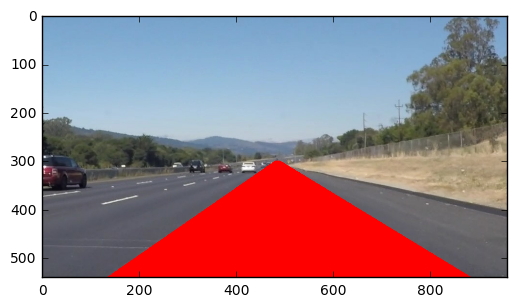

 94%|█████████▎| 208/222 [00:30<00:02,  6.93it/s]

In [5]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

square = np.array([[[480,300],[490,300],[900,550],[120,550]]],dtype=np.int32)
image = mpimg.imread('test_images/solidWhiteRight.jpg')
cv2.fillPoly(image,square,255)
plt.imshow(image)
